## Predicting Customer Churn


![](images/github-group-workflow.png)

In [1]:
import pandas as pd
import pyrsm as rsm

In [2]:
## load the data - this dataset must NOT be changed
s_mobile = pd.read_parquet("data/s_mobile.parquet")

If you want access to the full 1M row dataset, use the code below to download and use the data. The downside to using the dataset with 1M rows is, of course, that estimation time will increase substantially. I do NOT recommend you use this dataset to select your final model or for tuning hyper parameters. You can, however, use this larger dataset to re-estimate your chosen model and generate profit estimates for the representative sample.

In [4]:

s_mobile_1M = pd.read_parquet(
    "https://www.dropbox.com/scl/fi/pxuvd588f66kdo99hl91t/s_mobile_1M.parquet?rlkey=1dybd2o9isi1ipcdzkuk3866t&dl=1"
)
s_mobile_1M.head()


,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,refurb,smartphone,highcreditr,mcycle,car,travel,region,occupation,training,representative
0,U88927415,no,-1,-8,31,118,1,0,0,38,...,no,yes,no,no,no,no,SW,other,0.0,0
1,U94655060,no,0,-2,87,412,104,0,0,10,...,no,yes,no,no,no,yes,CS,student,1.0,0
2,U22910834,no,1,23,138,1252,0,3,0,19,...,no,yes,no,no,no,no,SE,student,1.0,0
3,U55939985,no,-1,-15,58,69,42,3,0,8,...,no,yes,yes,no,no,no,NE,other,NaN,1
4,U74897690,no,-9,-20,117,1002,175,4,0,11,...,yes,yes,no,no,no,no,SE,other,1.0,0


### EDA

In [5]:
s_mobile.head()

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,refurb,smartphone,highcreditr,mcycle,car,travel,region,occupation,training,representative
0,U86940794,yes,109,81,62,600,141,0,0,8,...,no,yes,no,no,no,no,CS,other,0.0,0
1,U56788559,no,0,3,54,146,0,0,0,8,...,no,yes,yes,no,no,no,SE,other,0.0,0
2,U47928407,no,0,-9,39,1158,96,0,1,9,...,no,yes,no,yes,no,yes,NW,professional,NaN,1
3,U75794640,no,0,-8,35,560,0,0,0,37,...,no,yes,yes,yes,no,no,NW,retired,1.0,0
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,no,yes,no,yes,yes,no,SW,other,NaN,1


In [6]:
s_mobile.dtypes

customer            object
churn             category
changer              int32
changem              int32
revenue              int32
mou                  int32
overage              int32
roam                 int32
conference           int32
months               int32
uniqsubs             int32
custcare             int32
retcalls           float64
dropvce              int32
eqpdays            float64
refurb            category
smartphone        category
highcreditr       category
mcycle            category
car               category
travel            category
region            category
occupation        category
training           float64
representative       int32
dtype: object

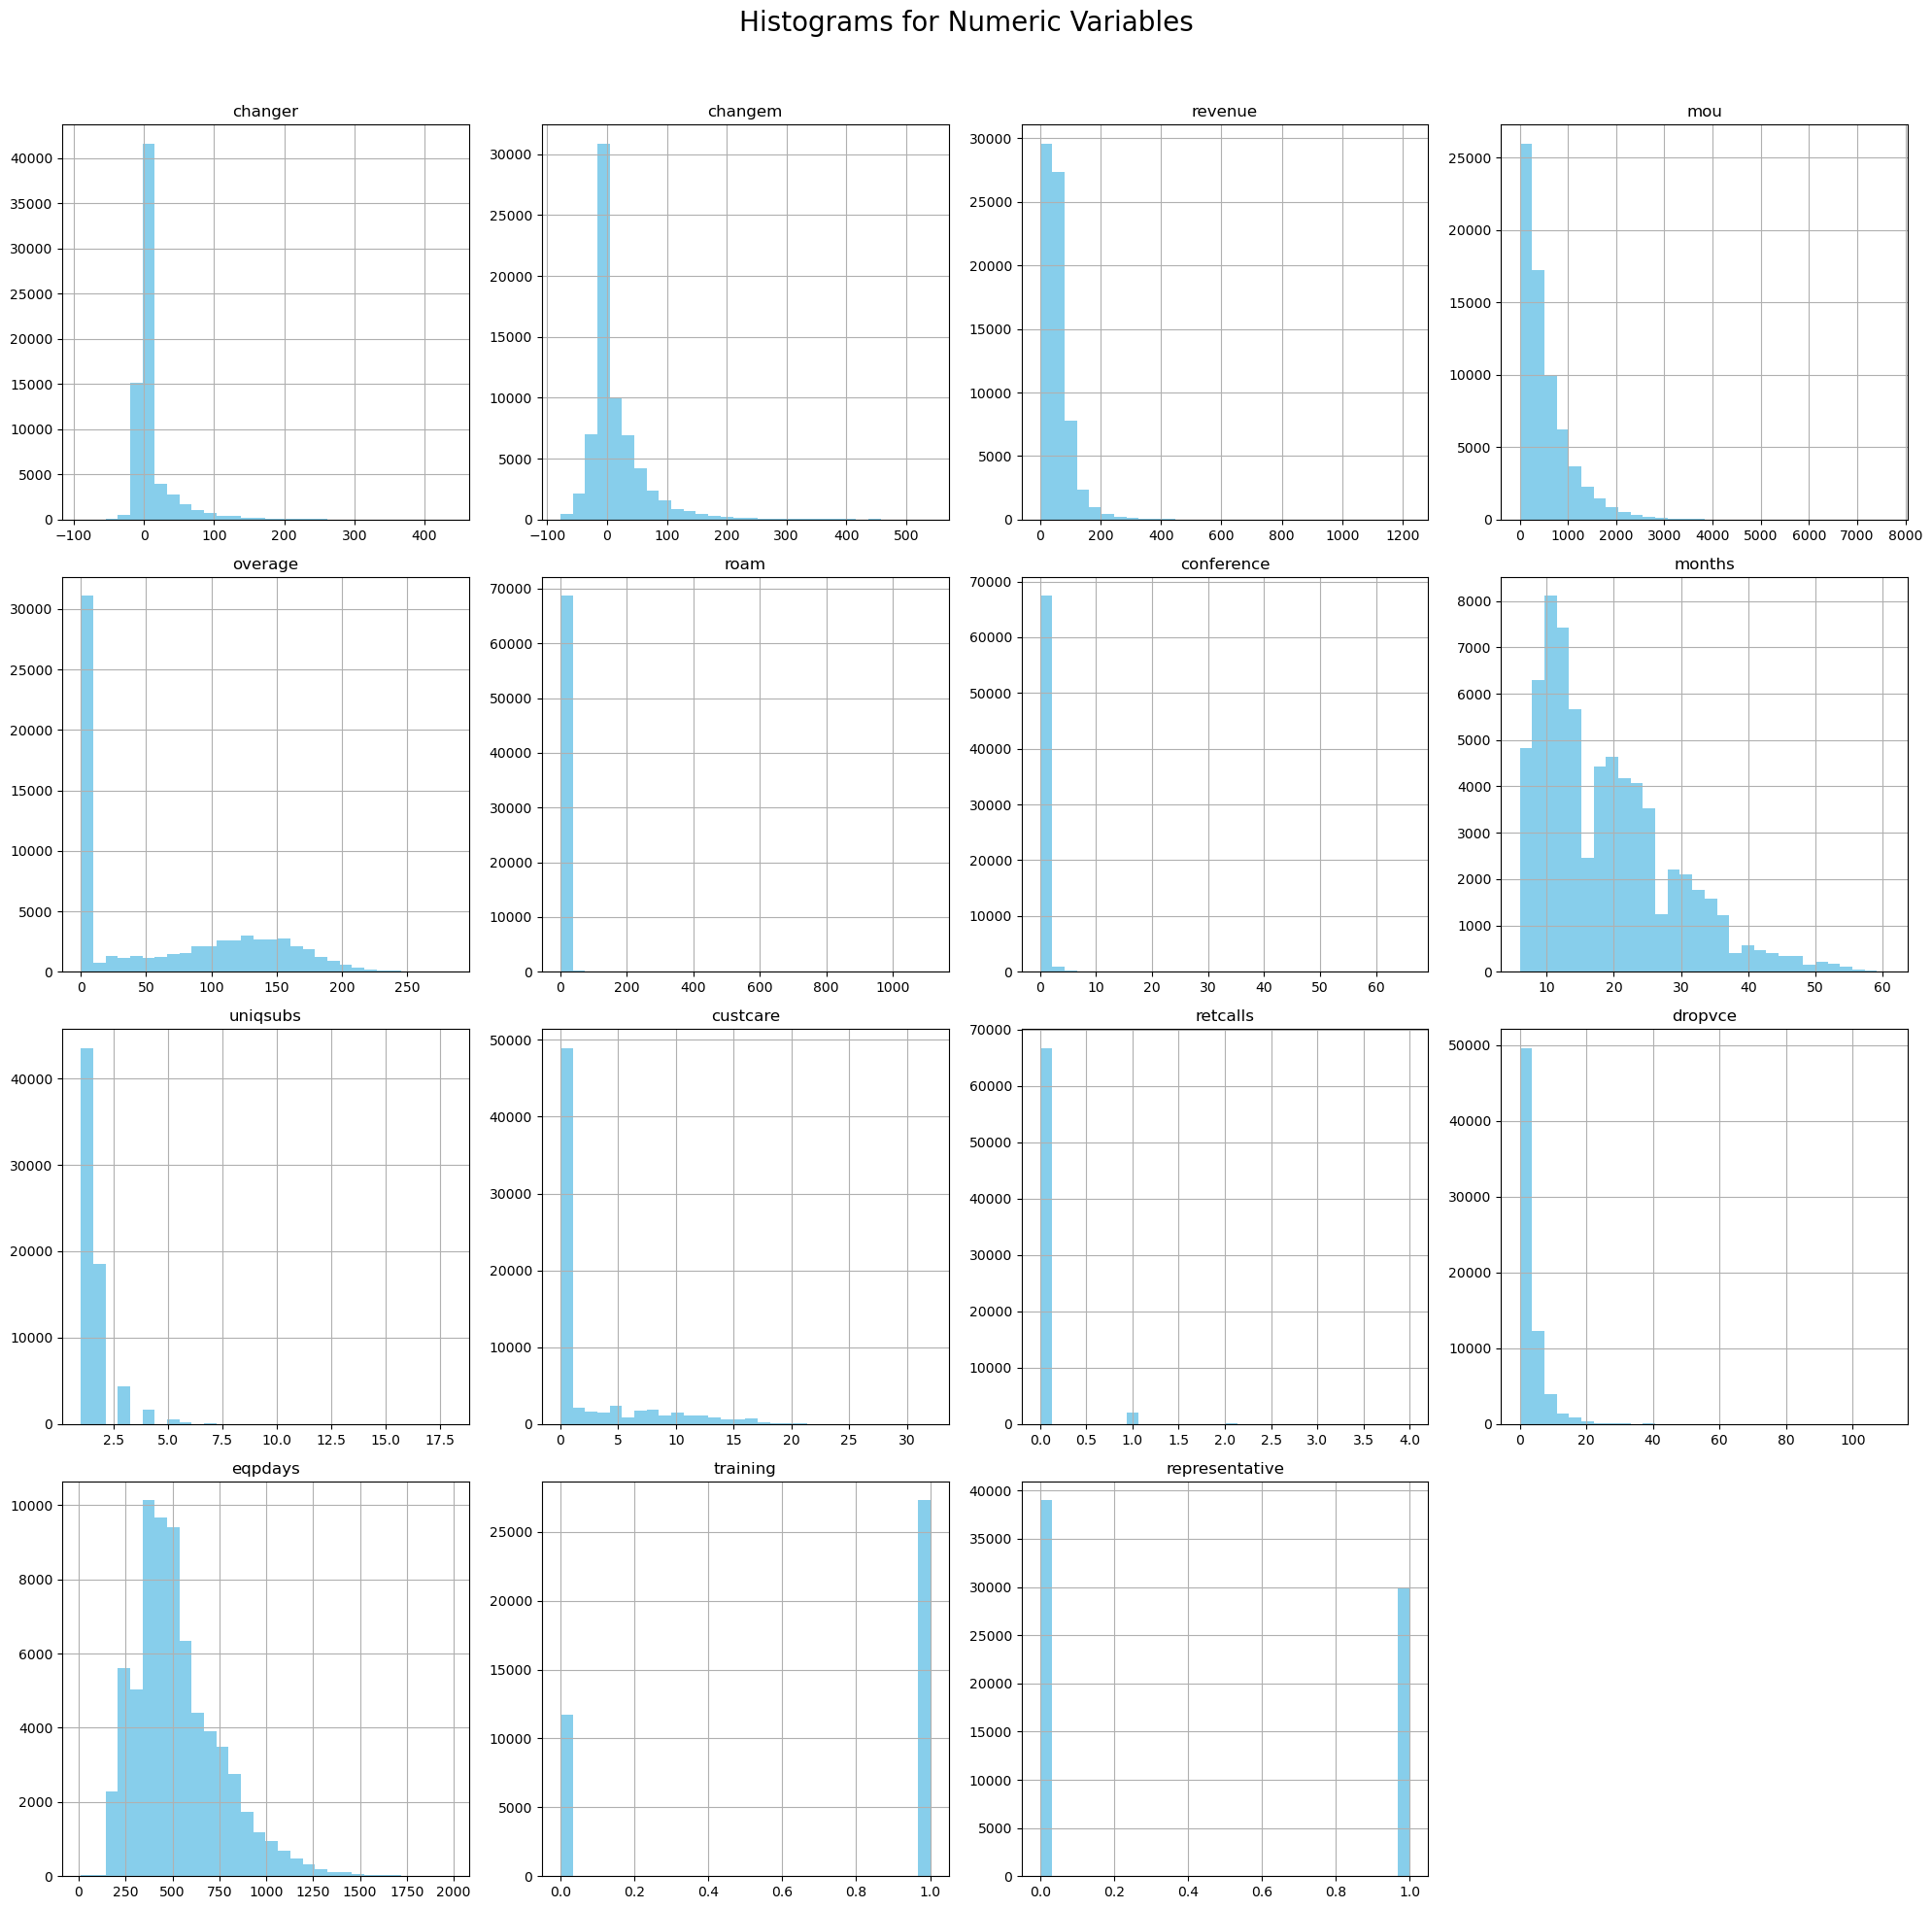

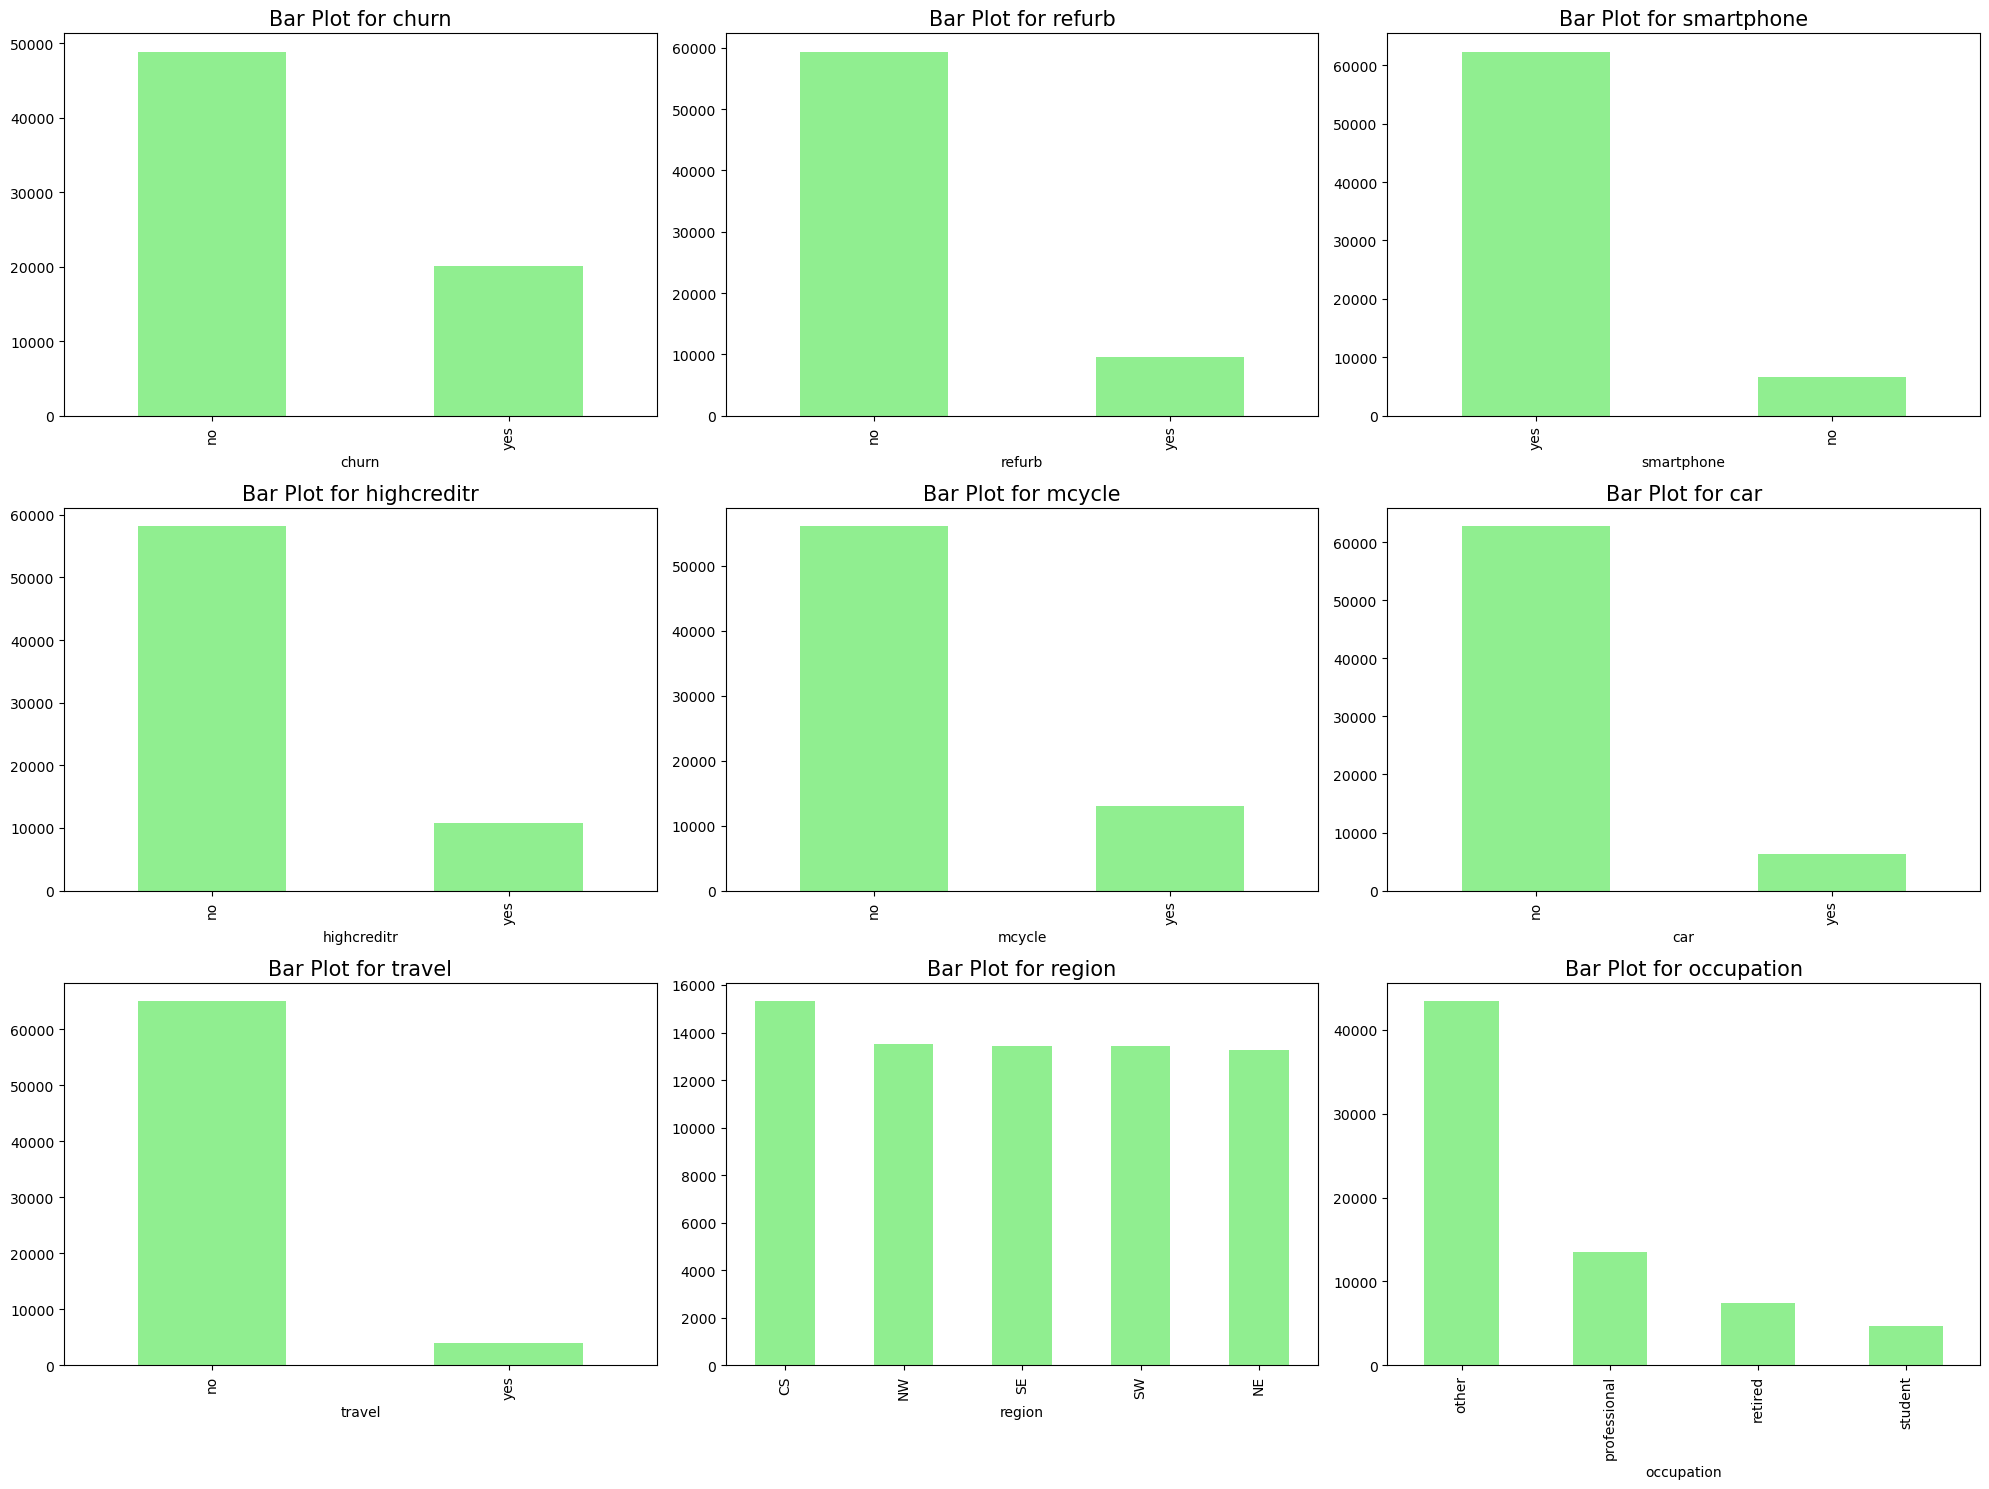

In [7]:
import matplotlib.pyplot as plt

# Separate the columns into categorical and numeric
categorical_cols = s_mobile.select_dtypes(include='category').columns
numeric_cols = s_mobile.select_dtypes(include=['int32', 'float64']).columns

# Plot histograms for numeric columns
s_mobile[numeric_cols].hist(figsize=(20, 20), bins=30, color='skyblue')
plt.suptitle('Histograms for Numeric Variables', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot histograms for categorical columns
nrows = (len(categorical_cols) + 2) // 3
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(20, nrows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for ax, col in zip(axes, categorical_cols):
    s_mobile[col].value_counts().plot(kind='bar', ax=ax, color='lightgreen')
    ax.set_title(f'Bar Plot for {col}', fontsize=15)

# Remove any unused subplots
for ax in axes[len(categorical_cols):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [8]:
s_mobile_train = s_mobile[s_mobile['training']==1]
s_mobile_test = s_mobile[s_mobile['training']==0]
s_mobile_representative = s_mobile[s_mobile['representative']==1]

In [9]:
s_mobile_train.shape, s_mobile_test.shape, s_mobile_representative.shape, s_mobile.shape

((27300, 25), (11700, 25), (30000, 25), (69000, 25))

Show descriptive stats in training data 

In [10]:
pd.get_dummies(
    s_mobile.loc[s_mobile.training == 1, "churn":],
    drop_first=True,
).agg(["mean", "std", "min", "max"]).T

,mean,std,min,max
changer,8.661245,28.956823,-62.0,305.0
changem,15.211392,51.885577,-78.0,521.0
revenue,57.211136,43.25895,0.0,856.0
mou,515.322308,525.458925,0.0,7668.0
overage,66.274286,69.258068,0.0,283.0
roam,1.197253,7.254327,0.0,692.0
conference,0.26348,1.083898,0.0,56.0
months,18.781502,9.595614,6.0,61.0
uniqsubs,1.546227,0.891051,1.0,18.0
custcare,2.288132,4.19297,0.0,32.0


Show churn in representative sample

In [11]:
pd.get_dummies(s_mobile.loc[s_mobile.representative == 1, "churn":], drop_first=True).agg(["mean", "std", "min", "max"])

,changer,changem,revenue,mou,overage,roam,conference,months,uniqsubs,custcare,...,mcycle_yes,car_yes,travel_yes,region_NE,region_NW,region_SE,region_SW,occupation_professional,occupation_student,occupation_retired
mean,8.310567,17.254533,56.634800,540.767067,61.723400,1.187867,0.296400,18.592767,1.501367,2.514533,...,0.187067,0.089767,0.0583,0.196167,0.201533,0.202133,0.200933,0.1736,0.055133,0.1405
std,28.496320,51.375390,43.339533,536.368824,67.846131,10.058579,1.284316,9.928488,0.840013,4.357846,...,0.389972,0.285852,0.234314,0.397103,0.401152,0.401598,0.400705,0.378771,0.228244,0.347511
min,-90.000000,-78.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,...,False,False,False,False,False,False,False,False,False,False
max,437.000000,540.000000,1223.000000,7359.000000,265.000000,1112.000000,66.000000,61.000000,12.000000,32.000000,...,True,True,True,True,True,True,True,True,True,True


In [12]:
class_weight_dict = {0: 49, 1: 1}
s_mobile["cweight"] = rsm.ifelse(s_mobile.churn == "yes", class_weight_dict[1], class_weight_dict[0])

In [13]:
s_mobile.head()

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,smartphone,highcreditr,mcycle,car,travel,region,occupation,training,representative,cweight
0,U86940794,yes,109,81,62,600,141,0,0,8,...,yes,no,no,no,no,CS,other,0.0,0,1
1,U56788559,no,0,3,54,146,0,0,0,8,...,yes,yes,no,no,no,SE,other,0.0,0,49
2,U47928407,no,0,-9,39,1158,96,0,1,9,...,yes,no,yes,no,yes,NW,professional,NaN,1,49
3,U75794640,no,0,-8,35,560,0,0,0,37,...,yes,yes,yes,no,no,NW,retired,1.0,0,49
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,yes,no,yes,yes,no,SW,other,NaN,1,49


 Binary encode mcycle, refurb, smartphone, creditr, car, travel.
 one hot encode region and occupation

In [14]:
s_mobile_cpy = s_mobile.copy()
s_mobile_cpy.head()

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,smartphone,highcreditr,mcycle,car,travel,region,occupation,training,representative,cweight
0,U86940794,yes,109,81,62,600,141,0,0,8,...,yes,no,no,no,no,CS,other,0.0,0,1
1,U56788559,no,0,3,54,146,0,0,0,8,...,yes,yes,no,no,no,SE,other,0.0,0,49
2,U47928407,no,0,-9,39,1158,96,0,1,9,...,yes,no,yes,no,yes,NW,professional,NaN,1,49
3,U75794640,no,0,-8,35,560,0,0,0,37,...,yes,yes,yes,no,no,NW,retired,1.0,0,49
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,yes,no,yes,yes,no,SW,other,NaN,1,49


In [15]:
# # One-hot encode 'region' and 'occupation'
#s_mobile_encoded = pd.get_dummies(s_mobile_cpy, columns=['region', 'occupation'])

# s_mobile_encoded.columns
s_mobile_encoded = s_mobile_cpy

In [16]:
binary_cols = ['mcycle', 'refurb', 'smartphone', 'highcreditr', 'travel', 'car']
#bool_cols = ['region_CS', 'region_NE', 'region_NW', 'region_SE', 'region_SW', 'occupation_other', 'occupation_professional', 'occupation_student', 'occupation_retired']
s_mobile_encoded[binary_cols] = s_mobile_encoded[binary_cols].apply(lambda x: x.cat.codes)
#s_mobile_encoded[bool_cols] = s_mobile_encoded[bool_cols].astype(int)

In [17]:
s_mobile_encoded.head()

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,smartphone,highcreditr,mcycle,car,travel,region,occupation,training,representative,cweight
0,U86940794,yes,109,81,62,600,141,0,0,8,...,1,0,0,0,0,CS,other,0.0,0,1
1,U56788559,no,0,3,54,146,0,0,0,8,...,1,1,0,0,0,SE,other,0.0,0,49
2,U47928407,no,0,-9,39,1158,96,0,1,9,...,1,0,1,0,1,NW,professional,NaN,1,49
3,U75794640,no,0,-8,35,560,0,0,0,37,...,1,1,1,0,0,NW,retired,1.0,0,49
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,1,0,1,1,0,SW,other,NaN,1,49


### Logistic Regression

Predicting churn


In [18]:
idvar = "customer"
rvar = "churn"
evar = [
       'changer', 'changem', 'revenue', 'mou', 'overage',
       'roam', 'conference', 'months', 'uniqsubs', 'custcare', 'retcalls',
       'dropvce', 'eqpdays', 'refurb', 'smartphone', 'highcreditr', 'mcycle',
       'car', 'travel',  'region', 'occupation'
]

In [19]:
clfw = rsm.model.logistic(
    data={"s_mobile": s_mobile_encoded[s_mobile_encoded.training == 1]},
    rvar="churn",
    lev="yes",
    evar=evar,
    weights="cweight",
)
clfw.summary()

Logistic regression (GLM)
Data                 : s_mobile
Response variable    : churn
Level                : yes
Explanatory variables: changer, changem, revenue, mou, overage, roam, conference, months, uniqsubs, custcare, retcalls, dropvce, eqpdays, refurb, smartphone, highcreditr, mcycle, car, travel, region, occupation
Weights used         : cweight
Null hyp.: There is no effect of x on churn
Alt. hyp.: There is an effect of x on churn

                             OR     OR%  coefficient  std.error  z.value p.value     
Intercept                 0.019  -98.1%       -3.962      0.053  -75.363  < .001  ***
region[NE]                0.644  -35.6%       -0.440      0.026  -16.635  < .001  ***
region[NW]                0.660  -34.0%       -0.416      0.026  -15.868  < .001  ***
region[SE]                0.651  -34.9%       -0.430      0.026  -16.420  < .001  ***
region[SW]                0.627  -37.3%       -0.467      0.026  -17.667  < .001  ***
occupation[professional]  1.416   41.6%

In [20]:
s_mobile_encoded["churn_pred"] = clfw.predict(s_mobile_encoded)['prediction']

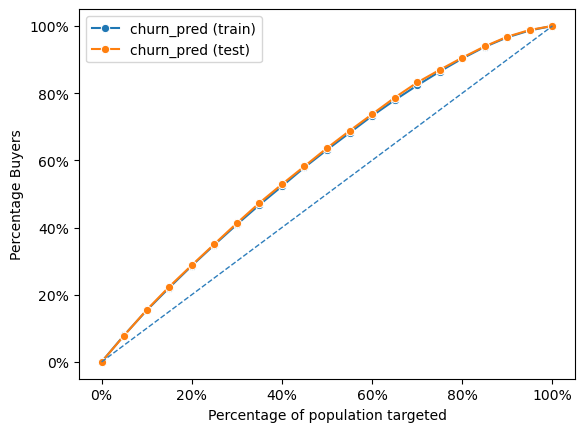

In [21]:
dct_clf_lr = {"train": s_mobile_encoded.query("training == 1"), "test": s_mobile_encoded.query("training == 0")}
fig_clf_lr = rsm.gains_plot(dct_clf_lr, "churn", "yes", "churn_pred", qnt=20)

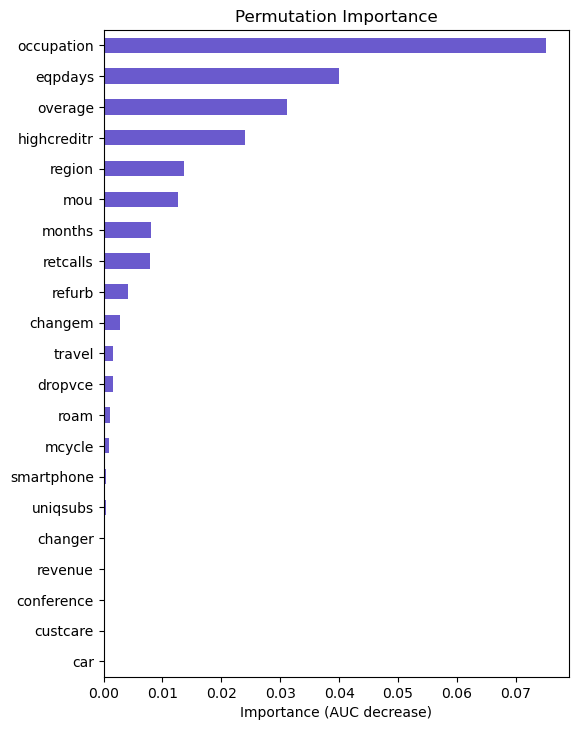

In [22]:
clfw.plot("vimp")


The model successfully identifies key churn drivers, with occupation, device age, overage, and tenure being the most impactful.
Train vs. test performance is stable, indicating the model generalizes well to unseen data.
Pseudo R-Squared (McFadden): 0.047 → Indicates moderate predictive power, which is expected for churn models due to the complexity of customer behavior.
AUC (Area Under the Curve): 0.688 → Suggests the model has reasonable discriminatory power (above random guessing but not highly predictive).

*Permutation Importance Plot:*

shuflling the feature values and measuring the impact on model performance, keeping all else constant, the top predictors are:

Occupation is the strongest predictor of churn, reinforcing that students and professionals need targeted retention strategies.
Device Age (eqpdays) is a major factor, confirming that customers with older devices are at high risk and should be targeted for early upgrade incentives.
Overage usage is highly important, meaning bill shock plays a role in customer dissatisfaction—plan recommendations and proactive alerts can help.
Credit rating (highcreditr) shows strong negative importance, supporting the idea that financially stable customers are more loyal.
Tenure (months) has a moderate impact, showing that early customer engagement is crucial to reducing churn risk.

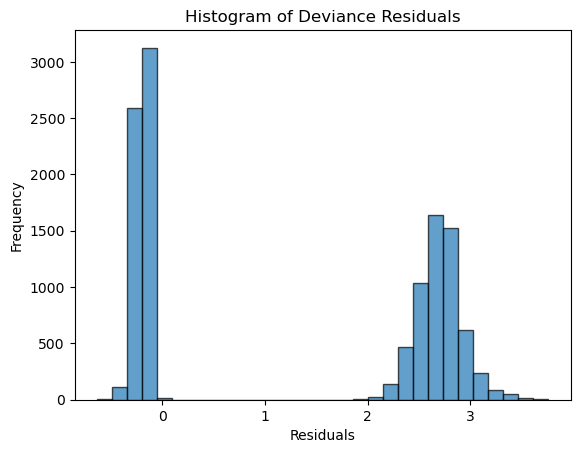

Skewness: 0.032495230425718565


In [23]:
# Compute deviance residuals
import numpy as np
import scipy.stats as stats


# Convert churn to binary
s_mobile_encoded['churn_binary'] = s_mobile_encoded['churn'].apply(lambda x: 1 if x == 'yes' else 0).astype(int)
residuals = np.sign(s_mobile_encoded[s_mobile_encoded['training']==0]['churn_binary'] - s_mobile_encoded[s_mobile_encoded['training']==0]['churn_pred']) * np.sqrt(-2 * (s_mobile_encoded[s_mobile_encoded['training']==0]['churn_binary'] * np.log(s_mobile_encoded[s_mobile_encoded['training']==0]['churn_pred']) + (1 - s_mobile_encoded[s_mobile_encoded['training']==0]['churn_binary']) * np.log(1 - s_mobile_encoded[s_mobile_encoded['training']==0]['churn_pred'])))


# Plot histogram
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title("Histogram of Deviance Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Compute skewness
skewness = stats.skew(residuals)
print(f"Skewness: {skewness}")

The histogram of deviance residuals shows bimodal distribution, meaning there are two distinct peaks.
The residual are skewed but not in a simple left or right skewed way. Instead, we have two separate clusters: One cluster around 0. Another cluster round 2-3.
This suggests that the logistic regression model may not be fitting well for certain groups of data points.

Log transformation is useful when residuals have a long tail, but here, the issue seems to be misclassification patterns rather than a simple skew. 
We will try adding interactions since this skeweness might be due to missing feature interactions.

In [24]:
ivar = ['overage:retcalls',  'occupation:region','months:highcreditr', 'retcalls:highcreditr', 'travel:roam', 'region:mou', 'region:highcreditr', 'retcalls:custcare', 'months:highcreditr','eqpdays:refurb', 'smartphone:highcreditr', 'retcalls:revenue']

These interaction terms were selected based on their potential to capture *nonlinear relationships* and *joint effects* that influence customer churn. Variables like overage:retcalls and overage:mou reflect the interplay between high usage, overage charges, and retention calls, indicating customer dissatisfaction. Financial stability and long-term engagement are considered through interactions like months:highcreditr and retcalls:highcreditr, highlighting how tenure and credit rating jointly impact churn. The occupation:region and region:mou interactions recognize that professional and regional differences may shape usage patterns and service expectations. Behavioral insights are integrated with retcalls:custcare and retcalls:revenue, capturing whether high-revenue customers frequently seeking support are more likely to leave. Device-related interactions such as eqpdays:refurb and smartphone:highcreditr acknowledge that handset age and financial stability could drive churn decisions. Lastly, travel:roam and changer:changem account for dynamic usage behaviors, ensuring the model better differentiates between customer segments at risk of churning. These interactions enhance the logistic regression model by allowing it to capture complex dependencies that individual features might miss.

In [25]:
clfw_int = rsm.model.logistic(
    data={"s_mobile": s_mobile_encoded[s_mobile_encoded.training == 1]},
    rvar="churn",
    lev="yes",
    evar=evar,
    ivar=ivar,
    weights="cweight",
)
clfw_int.summary()

Logistic regression (GLM)
Data                 : s_mobile
Response variable    : churn
Level                : yes
Explanatory variables: changer, changem, revenue, mou, overage, roam, conference, months, uniqsubs, custcare, retcalls, dropvce, eqpdays, refurb, smartphone, highcreditr, mcycle, car, travel, region, occupation
Weights used         : cweight
Null hyp.: There is no effect of x on churn
Alt. hyp.: There is an effect of x on churn

                                        OR     OR%  coefficient  std.error  z.value p.value     
Intercept                            0.018  -98.2%       -4.023      0.057  -70.339  < .001  ***
region[NE]                           0.714  -28.6%       -0.337      0.046   -7.328  < .001  ***
region[NW]                           0.711  -28.9%       -0.341      0.045   -7.512  < .001  ***
region[SE]                           0.730  -27.0%       -0.314      0.045   -6.970  < .001  ***
region[SW]                           0.639  -36.1%       -0.448      0

In [26]:
s_mobile_encoded["churn_pred_int"] = clfw_int.predict(s_mobile_encoded)['prediction']

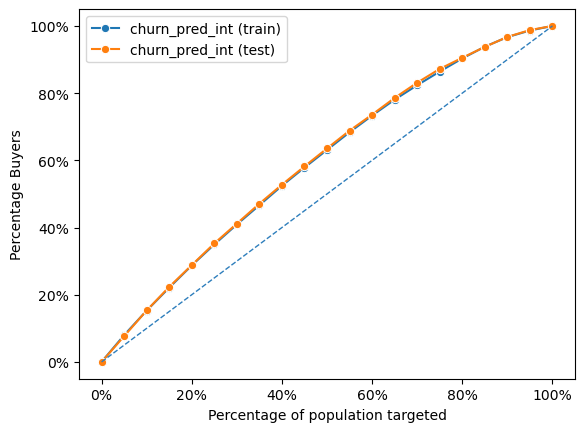

In [27]:
dct_clf_lr1 = {"train": s_mobile_encoded.query("training == 1"), "test": s_mobile_encoded.query("training == 0")}
fig_clf_lr1 = rsm.gains_plot(dct_clf_lr1, "churn", "yes", "churn_pred_int", qnt=20)

Since the perfromace of the model is not improving even after adding interactions we will build our model with NN, RF and XGboost and pick the best out of it.

In [28]:
#Check avg prediction value
s_mobile_encoded[s_mobile_encoded['training'].isna()]['churn_pred_int'].mean()

0.01986239484652984

The avg prediction is 1.99% and is close to actual churn rate of 2%

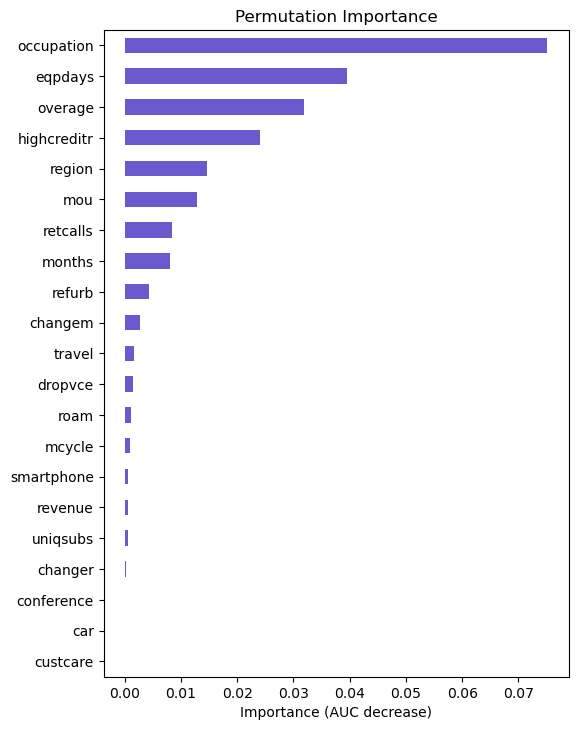

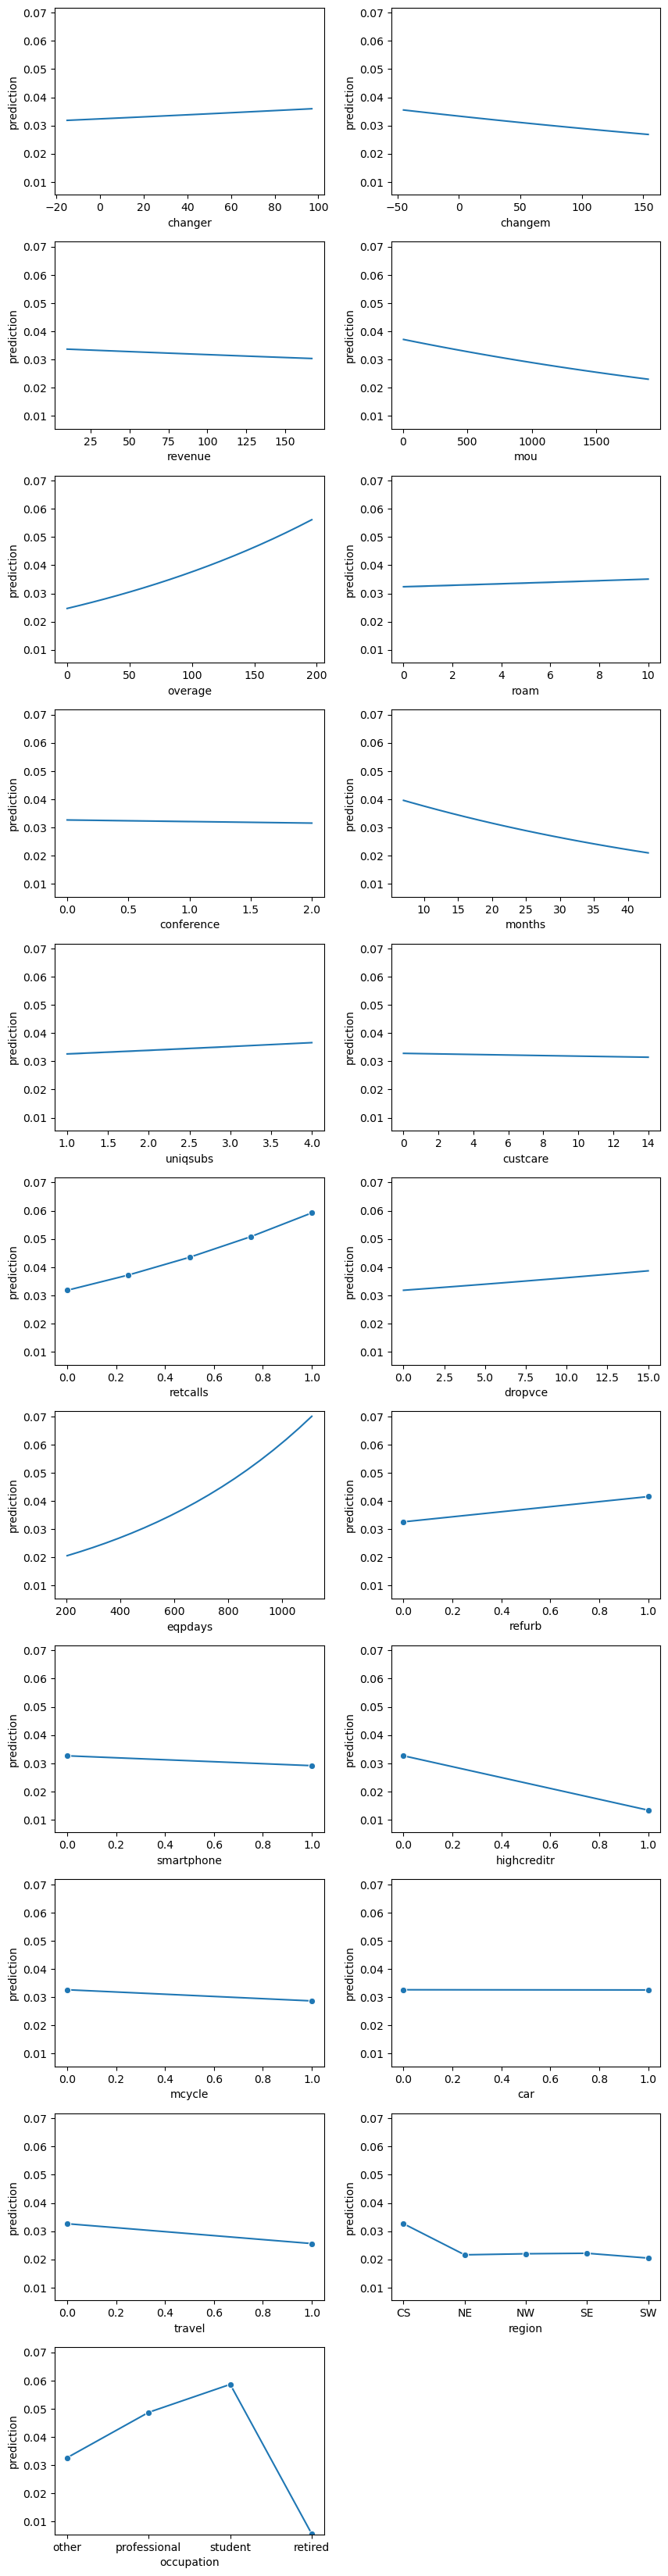

In [29]:
clfw_int.plot("vimp")
clfw_int.plot("pred")

### Random Forest

In [30]:
s_mobile_rf = s_mobile.copy()

#change binary columns to integers
binary_cols = ['mcycle', 'refurb', 'smartphone', 'highcreditr', 'travel', 'car']
s_mobile_rf[binary_cols] = s_mobile_rf[binary_cols].apply(lambda x: x.cat.codes)

# One-hot encode 'region' and 'occupation' and convert to integers
s_mobile_rf = pd.get_dummies(s_mobile_rf, columns=['region', 'occupation'], drop_first=True)
bool_cols = ['region_NE', 'region_NW', 'region_SE', 'region_SW', 'occupation_professional', 'occupation_student', 'occupation_retired']
s_mobile_rf[bool_cols] = s_mobile_rf[bool_cols].astype(int)
s_mobile_rf.head()

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,training,representative,cweight,region_NE,region_NW,region_SE,region_SW,occupation_professional,occupation_student,occupation_retired
0,U86940794,yes,109,81,62,600,141,0,0,8,...,0.0,0,1,0,0,0,0,0,0,0
1,U56788559,no,0,3,54,146,0,0,0,8,...,0.0,0,49,0,0,1,0,0,0,0
2,U47928407,no,0,-9,39,1158,96,0,1,9,...,NaN,1,49,0,1,0,0,1,0,0
3,U75794640,no,0,-8,35,560,0,0,0,37,...,1.0,0,49,0,1,0,0,0,0,1
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,NaN,1,49,0,0,0,1,0,0,0


In [31]:
#dropped region_cs and occupation_other

In [32]:
s_mobile_rf.columns

Index(['customer', 'churn', 'changer', 'changem', 'revenue', 'mou', 'overage',
       'roam', 'conference', 'months', 'uniqsubs', 'custcare', 'retcalls',
       'dropvce', 'eqpdays', 'refurb', 'smartphone', 'highcreditr', 'mcycle',
       'car', 'travel', 'training', 'representative', 'cweight', 'region_NE',
       'region_NW', 'region_SE', 'region_SW', 'occupation_professional',
       'occupation_student', 'occupation_retired'],
      dtype='object')

In [33]:
idvar_rf = "customer"
rvar_rf = "churn"
evar_rf = [
       'changer', 'changem', 'revenue', 'mou', 'overage',
       'roam', 'conference', 'months', 'uniqsubs', 'custcare', 'retcalls',
       'dropvce', 'eqpdays', 'refurb', 'smartphone', 'highcreditr', 'mcycle',
       'car', 'travel', 'region_NE', 'region_NW', 'region_SE', 'region_SW', 
       'occupation_professional', 'occupation_student', 'occupation_retired'
]

In [34]:
sample_weight = s_mobile_rf.loc[s_mobile_rf.training == 1, "cweight"]

In [35]:
rf0 = rsm.model.rforest(
    data ={"s_mobile_rf": s_mobile_rf.query("training == 1")},
    rvar="churn",
    lev="yes",
    evar= evar_rf,
    random_state=1234,
    
)
# Fit the model with sample weights
rf0.fitted.fit(rf0.data_onehot, s_mobile_rf.loc[s_mobile_rf["training"] == 1, "churn"], sample_weight=sample_weight)
rf0.summary()

Random Forest
Data                 : s_mobile_rf
Response variable    : churn
Level                : yes
Explanatory variables: changer, changem, revenue, mou, overage, roam, conference, months, uniqsubs, custcare, retcalls, dropvce, eqpdays, refurb, smartphone, highcreditr, mcycle, car, travel, region_NE, region_NW, region_SE, region_SW, occupation_professional, occupation_student, occupation_retired
OOB                  : True
Model type           : classification
Nr. of features      : (26, 26)
Nr. of observations  : 27,300
max_features         : sqrt (5)
n_estimators         : 100
min_samples_leaf     : 1
max_samples          : 1.0
random_state         : 1234
AUC                  : 0.714

Estimation data      :
 changer  changem  revenue  mou  overage  roam  conference  months  uniqsubs  custcare  retcalls  dropvce  eqpdays  refurb  smartphone  highcreditr  mcycle  car  travel  region_NE  region_NW  region_SE  region_SW  occupation_professional  occupation_student  occupation_retir

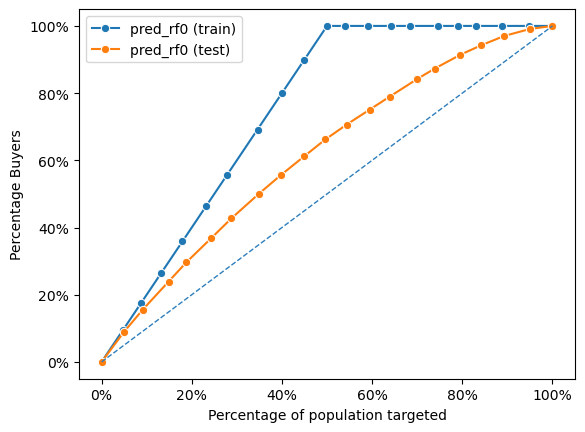

In [36]:
s_mobile_rf["pred_rf0"] = rf0.predict(s_mobile_rf)['prediction']
dct_clf_rf0 = {"train": s_mobile_rf.query("training == 1"), "test": s_mobile_rf.query("training == 0")}
fig_clf_rf0 = rsm.gains_plot(dct_clf_rf0, "churn", "yes", "pred_rf0", qnt=20)

Tuning random forest model

In [37]:
import math

sqrt_count_evar_rf = math.sqrt(len(evar_rf))
sqrt_count_evar_rf

5.0990195135927845

In [38]:
param_gridrf = {
    "n_estimators": list(range(200, 500, 50)),
    "max_depth": np.arange(5, 10, 1),
    "max_samples": np.arange(0.5, 0.8, 0.05)
}


In [39]:
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

if os.path.exists('cv-objects/rf-cross-validation-object.pkl'):
    cvrfc=rsm.load_state('cv-objects/rf-cross-validation-object.pkl')["cv"]
else:
    stratified_k_foldrf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    cvrfc =GridSearchCV(rf0.fitted, param_gridrf, scoring = {"AUC": "roc_auc"}, cv=stratified_k_foldrf, n_jobs=5,refit="AUC", verbose=5).fit(rf0.data_onehot, rf0.data.churn)
    if not os.path.exists('cv-objects'):
        os.mkdir('cv-objects')
    rsm.save_state({"cv": cvrfc},'cv-objects/rf-cross-validation-object.pkl')

In [40]:
cvrfc.best_params_

{'max_depth': 9, 'max_samples': 0.8000000000000003, 'n_estimators': 450}

In [41]:
rf1 = rsm.model.rforest(
    data ={"s_mobile_rf": s_mobile_rf.query("training == 1")},
    rvar="churn",
    lev="yes",
    evar= evar_rf,
    random_state=1234,
    **cvrfc.best_params_
    #max_depth = 7,
    #max_samples = 0.75,
    #n_estimators = 400
)
# Fit the model with sample weights
rf1.fitted.fit(rf1.data_onehot, s_mobile_rf.loc[s_mobile_rf["training"] == 1, "churn"], sample_weight=sample_weight)
rf1.summary()

Random Forest
Data                 : s_mobile_rf
Response variable    : churn
Level                : yes
Explanatory variables: changer, changem, revenue, mou, overage, roam, conference, months, uniqsubs, custcare, retcalls, dropvce, eqpdays, refurb, smartphone, highcreditr, mcycle, car, travel, region_NE, region_NW, region_SE, region_SW, occupation_professional, occupation_student, occupation_retired
OOB                  : True
Model type           : classification
Nr. of features      : (26, 26)
Nr. of observations  : 27,300
max_features         : sqrt (5)
n_estimators         : 450
min_samples_leaf     : 1
max_samples          : 0.8000000000000003
random_state         : 1234
AUC                  : 0.695
Extra arguments      : max_depth=9

Estimation data      :
 changer  changem  revenue  mou  overage  roam  conference  months  uniqsubs  custcare  retcalls  dropvce  eqpdays  refurb  smartphone  highcreditr  mcycle  car  travel  region_NE  region_NW  region_SE  region_SW  occupation_

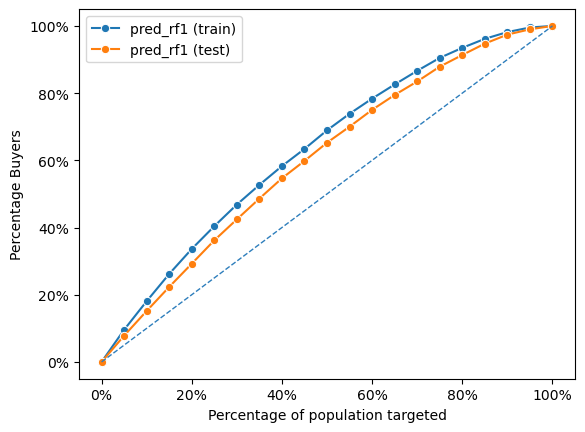

In [42]:
s_mobile_rf["pred_rf1"] = rf1.predict(s_mobile_rf)['prediction']
dct_clf_rf1 = {"train": s_mobile_rf.query("training == 1"), "test": s_mobile_rf.query("training == 0")}
fig_clf_rf1 = rsm.gains_plot(dct_clf_rf1, "churn", "yes", "pred_rf1", qnt=20)

Even after tuning multiple times, the RF model has an AUC of 0.695 and overfitting is still present. The model is not able to capture the complex relationships between features and the target variable. We will try building a model using XGBoost and Neural Networks to see if we can improve the performance.

In [43]:
#Check avg prediction value
s_mobile_rf[s_mobile_rf['training'].isna()]['pred_rf1'].mean()

0.028347355888315127

The average prediction is 2.83% which is a little over the actual churn rate of 2%

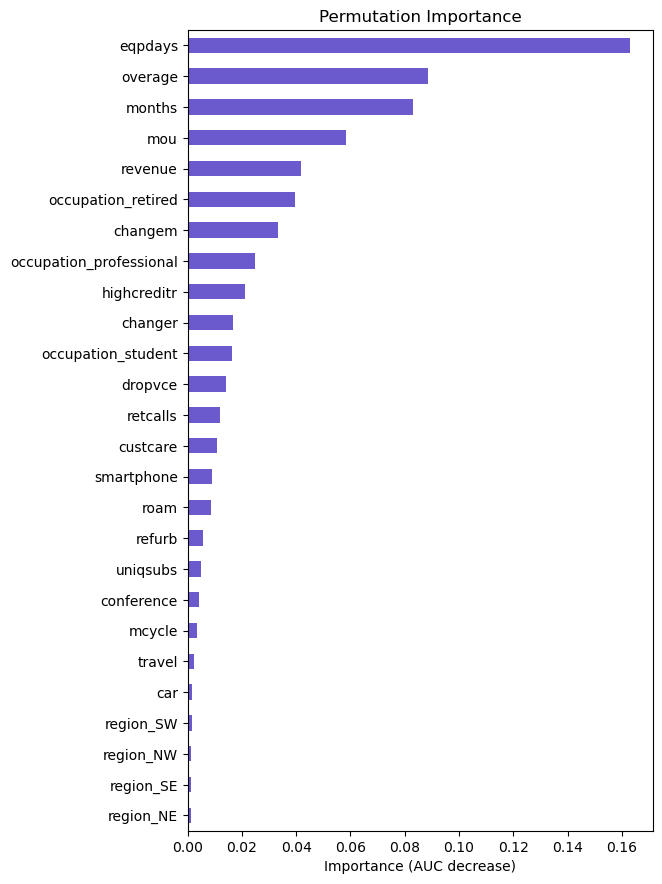

In [44]:
rf1.plot("vimp")

## Neural Network

In [45]:
#scale data
s_mobile_scaled = s_mobile.copy()
s_mobile_scaled.drop(columns=['cweight'], inplace=True)
s_mobile_scaled = rsm.scale_df(s_mobile_scaled, sf=1)
s_mobile_scaled

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,refurb,smartphone,highcreditr,mcycle,car,travel,region,occupation,training,representative
0,U86940794,yes,3.466056,1.263128,0.116043,0.139952,1.120165,-0.131612,-0.235465,-1.099384,...,no,yes,no,no,no,no,CS,other,0.0,0
1,U56788559,no,-0.296776,-0.253593,-0.068123,-0.716618,-0.933092,-0.131612,-0.235465,-1.099384,...,no,yes,yes,no,no,no,SE,other,0.0,0
2,U47928407,no,-0.296776,-0.486935,-0.413436,1.192741,0.464870,-0.131612,0.616820,-0.996604,...,no,yes,no,yes,no,yes,NW,professional,NaN,1
3,U75794640,no,-0.296776,-0.467489,-0.505519,0.064484,-0.933092,-0.131612,-0.235465,1.881228,...,no,yes,yes,yes,no,no,NW,retired,1.0,0
4,U41010771,no,-0.365819,-0.467489,0.990836,2.570045,0.697864,0.859202,-0.235465,0.133973,...,no,yes,no,yes,yes,no,SW,other,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68995,U97081813,no,-0.296776,-0.603605,-0.551561,-0.899629,-0.933092,-0.131612,-0.235465,0.031193,...,no,yes,no,yes,yes,no,SW,other,NaN,1
68996,U24071089,no,-0.296776,1.535360,-0.620624,-0.844914,-0.933092,-0.131612,-0.235465,-0.071587,...,no,no,no,yes,yes,no,SE,other,1.0,0
68997,U52895026,yes,-0.296776,-0.214703,-0.321353,-0.520399,-0.161301,-0.131612,-0.235465,0.647871,...,no,no,no,no,no,no,CS,student,0.0,0
68998,U69840472,yes,-0.400340,-0.875837,-0.367394,-0.448704,-0.933092,-0.131612,-0.235465,0.031193,...,no,yes,no,no,no,no,CS,other,1.0,0


In [46]:
#change binary columns to integers
binary_cols = ['mcycle', 'refurb', 'smartphone', 'highcreditr', 'travel', 'car']
s_mobile_scaled[binary_cols] = s_mobile_scaled[binary_cols].apply(lambda x: x.cat.codes)

# One-hot encode 'region' and 'occupation' and convert to integers
s_mobile_scaled = pd.get_dummies(s_mobile_scaled, columns=['region', 'occupation'], drop_first=True)
bool_cols = ['region_NE', 'region_NW', 'region_SE', 'region_SW', 'occupation_professional', 'occupation_student', 'occupation_retired']
s_mobile_scaled[bool_cols] = s_mobile_scaled[bool_cols].astype(int)
s_mobile_scaled.head()


,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,travel,training,representative,region_NE,region_NW,region_SE,region_SW,occupation_professional,occupation_student,occupation_retired
0,U86940794,yes,3.466056,1.263128,0.116043,0.139952,1.120165,-0.131612,-0.235465,-1.099384,...,0,0.0,0,0,0,0,0,0,0,0
1,U56788559,no,-0.296776,-0.253593,-0.068123,-0.716618,-0.933092,-0.131612,-0.235465,-1.099384,...,0,0.0,0,0,0,1,0,0,0,0
2,U47928407,no,-0.296776,-0.486935,-0.413436,1.192741,0.464870,-0.131612,0.616820,-0.996604,...,1,NaN,1,0,1,0,0,1,0,0
3,U75794640,no,-0.296776,-0.467489,-0.505519,0.064484,-0.933092,-0.131612,-0.235465,1.881228,...,0,1.0,0,0,1,0,0,0,0,1
4,U41010771,no,-0.365819,-0.467489,0.990836,2.570045,0.697864,0.859202,-0.235465,0.133973,...,0,NaN,1,0,0,0,1,0,0,0


In [47]:
#occupation_other and region_CS dropped
idvar_nn = "customer"
rvar_nn = "churn"
evar_nn = [
       'changer', 'changem', 'revenue', 'mou', 'overage',
       'roam', 'conference', 'months', 'uniqsubs', 'custcare', 'retcalls',
       'dropvce', 'eqpdays', 'refurb', 'smartphone', 'highcreditr', 'mcycle',
       'car', 'travel', 'region_NE', 'region_NW', 'region_SE', 'region_SW', 
       'occupation_professional', 'occupation_student', 'occupation_retired'
]

In [48]:
class_weight_dict = {0: 49, 1: 1}
s_mobile_scaled["cweight"] = rsm.ifelse(s_mobile_scaled.churn == "yes", class_weight_dict[1], class_weight_dict[0])

In [49]:
sample_weight = s_mobile_scaled.loc[s_mobile_scaled.training == 1, "cweight"]

mlp in sklearn doesn’t have an option to use frequency weights. 

In [50]:
nn0 = rsm.mlp({
    "sm_scaled": s_mobile_scaled.query("training == 1")}, 
    rvar="churn",
    lev="yes",
    evar= evar_nn,
    hidden_layer_sizes=(1,),
    mod_type="classification"
)

nn0.summary()

Multi-layer Perceptron (NN)
Data                 : sm_scaled
Response variable    : churn
Level                : yes
Explanatory variables: changer, changem, revenue, mou, overage, roam, conference, months, uniqsubs, custcare, retcalls, dropvce, eqpdays, refurb, smartphone, highcreditr, mcycle, car, travel, region_NE, region_NW, region_SE, region_SW, occupation_professional, occupation_student, occupation_retired
Model type           : classification
Nr. of features      : (26, 26)
Nr. of weights       : 29
Nr. of observations  : 27,300
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.689

Raw data             :
  changer   changem   revenue       mou   overage      roam  conference    months  uniqsubs  custcare  retcalls   dropvce   eqpdays  refurb  smartphone  highcreditr  mcycle 

In [51]:
import math

sqrt_count_evar_nn = math.sqrt(len(evar_nn))
sqrt_count_evar_nn

5.0990195135927845

In [52]:
hls = [(2,2), (3,), (3,2), (4,), (4,3), (5,), (3,5), (4,5), (4,4), (5,3), (5,5), (6,2), (6,5), (7,2) ,(7,5), (6,6), (7,7)]
param_grid_nn = {
    'hidden_layer_sizes': hls,
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}
param_grid_nn

{'hidden_layer_sizes': [(2, 2),
  (3,),
  (3, 2),
  (4,),
  (4, 3),
  (5,),
  (3, 5),
  (4, 5),
  (4, 4),
  (5, 3),
  (5, 5),
  (6, 2),
  (6, 5),
  (7, 2),
  (7, 5),
  (6, 6),
  (7, 7)],
 'alpha': [0.0001, 0.001, 0.01, 0.1]}

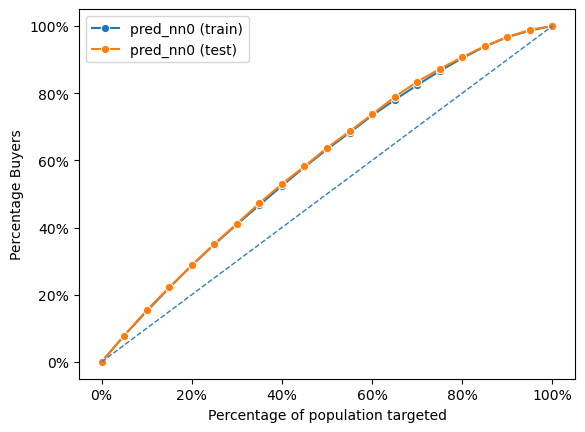

In [53]:
s_mobile_scaled["pred_nn0"] = nn0.predict(s_mobile_scaled)['prediction']
dct_clf_nn0 = {"train": s_mobile_scaled.query("training == 1"), "test": s_mobile_scaled.query("training == 0")}
fig_clf_nn0 = rsm.gains_plot(dct_clf_nn0, "churn", "yes", "pred_nn0", qnt=20)

In [54]:
if os.path.exists('cv-objects/cross-validation-object_nn0.pkl'):
    cvnn=rsm.load_state('cv-objects/cross-validation-object_nn0.pkl')["cv"]
else:
    stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    cvnn=GridSearchCV(nn0.fitted, param_grid_nn, scoring = {"AUC": "roc_auc"}, cv=stratified_k_fold, n_jobs=5,refit="AUC", verbose=5).fit(nn0.data_onehot, nn0.data.churn)
    if not os.path.exists('cv-objects'):
        os.mkdir('cv-objects')
    rsm.save_state({"cv": cvnn},'cv-objects/cross-validation-object_nn0.pkl')

In [55]:
cvnn.best_params_

{'alpha': 0.001, 'hidden_layer_sizes': (6, 2)}

In [56]:
nn1 = rsm.mlp({
    "sm_scaled": s_mobile_scaled.query("training == 1")}, 
    rvar="churn",
    lev="yes",
    evar= evar_nn,
    mod_type="classification",
    random_state=1234,
    **cvnn.best_params_    
)

nn1.summary()

Multi-layer Perceptron (NN)
Data                 : sm_scaled
Response variable    : churn
Level                : yes
Explanatory variables: changer, changem, revenue, mou, overage, roam, conference, months, uniqsubs, custcare, retcalls, dropvce, eqpdays, refurb, smartphone, highcreditr, mcycle, car, travel, region_NE, region_NW, region_SE, region_SW, occupation_professional, occupation_student, occupation_retired
Model type           : classification
Nr. of features      : (26, 26)
Nr. of weights       : 179
Nr. of observations  : 27,300
Hidden_layer_sizes   : (6, 2)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.739

Raw data             :
  changer   changem   revenue       mou   overage      roam  conference    months  uniqsubs  custcare  retcalls   dropvce   eqpdays  refurb  smartphone  highcreditr  mcycl

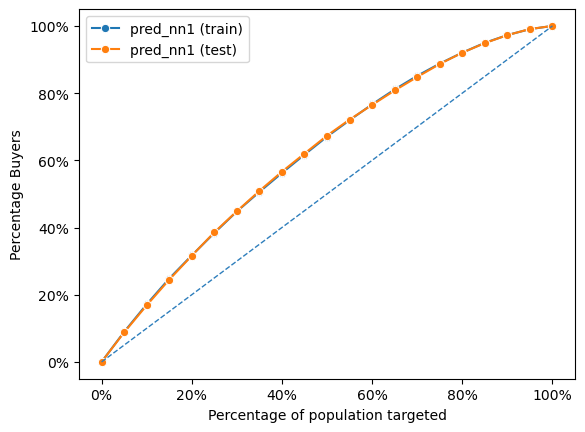

In [57]:
s_mobile_scaled["pred_nn1"] = nn1.predict(s_mobile_scaled)['prediction']
dct_clf_nn1 = {"train": s_mobile_scaled.query("training == 1"), "test": s_mobile_scaled.query("training == 0")}
fig_clf_nn1 = rsm.gains_plot(dct_clf_nn1, "churn", "yes", "pred_nn1", qnt=20)

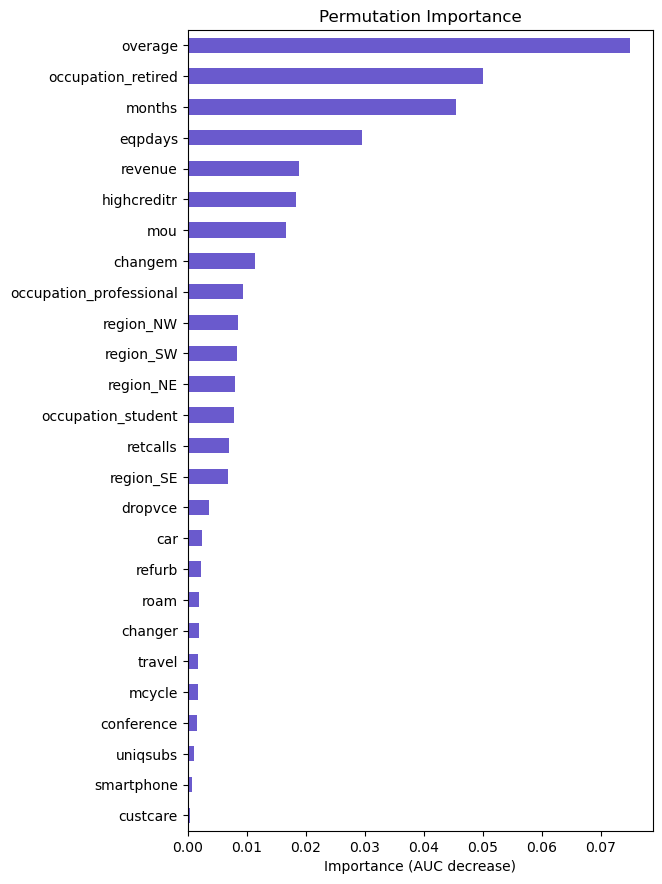

In [58]:
nn1.plot("vimp")

In [59]:
#Check avg prediction value
s_mobile_scaled[s_mobile_scaled['training'].isna()]['pred_nn1'].mean()

0.4167825206163245

The average prediction is 41.7% which is a lot over the actual churn rate of 2%

### XGBoost

In [60]:
s_mobile_xgb = s_mobile.copy()

# One-hot encode 'region' and 'occupation'
s_mobile_encoded_x = pd.get_dummies(s_mobile_xgb, columns=['region', 'occupation'],drop_first=True)

# Display the encoded dataframe
# Convert binary columns to 0 and 1 after one-hot encoding
binary_cols = ['mcycle', 'refurb', 'smartphone', 'highcreditr', 'travel', 'car']
s_mobile_encoded_x[binary_cols] = s_mobile_encoded_x[binary_cols].apply(lambda x: x.cat.codes)
#s_mobile_encoded = pd.get_dummies(s_mobile_encoded, columns=['region', 'occupation'], drop_first=True)

# Convert True/False columns to binary (0 and 1)
true_false_cols = [ 'region_NE', 'region_NW', 'region_SE', 'region_SW', 
                    'occupation_professional', 'occupation_student', 'occupation_retired']
s_mobile_encoded_x[true_false_cols] = s_mobile_encoded_x[true_false_cols].astype(int)

# Display the encoded dataframe
s_mobile_encoded_x.head()

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,training,representative,cweight,region_NE,region_NW,region_SE,region_SW,occupation_professional,occupation_student,occupation_retired
0,U86940794,yes,109,81,62,600,141,0,0,8,...,0.0,0,1,0,0,0,0,0,0,0
1,U56788559,no,0,3,54,146,0,0,0,8,...,0.0,0,49,0,0,1,0,0,0,0
2,U47928407,no,0,-9,39,1158,96,0,1,9,...,NaN,1,49,0,1,0,0,1,0,0
3,U75794640,no,0,-8,35,560,0,0,0,37,...,1.0,0,49,0,1,0,0,0,0,1
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,NaN,1,49,0,0,0,1,0,0,0


In [61]:
evar_x = [ 'changer', 'changem', 'revenue', 'mou', 'overage',
       'roam', 'conference', 'months', 'uniqsubs', 'custcare', 'retcalls',
       'dropvce', 'eqpdays', 'refurb', 'smartphone', 'highcreditr', 'mcycle',
       'car', 'travel',  'region_NE', 'region_NW', 'region_SE',
       'region_SW', 'occupation_professional', 'occupation_student', 
       'occupation_retired']

In [62]:
xgb1 = rsm.model.xgboost(
    {"s_mobile_xgb": s_mobile_encoded_x[s_mobile_encoded_x.training == 1]},
    rvar="churn",
    lev="yes",
    evar=evar_x,
    n_estimators=100,
    max_depth=5,
    random_state=1234,
    scale_pos_weight = 49,
)
xgb1.summary()

XGBoost
Data                 : s_mobile_xgb
Response variable    : churn
Level                : yes
Explanatory variables: changer, changem, revenue, mou, overage, roam, conference, months, uniqsubs, custcare, retcalls, dropvce, eqpdays, refurb, smartphone, highcreditr, mcycle, car, travel, region_NE, region_NW, region_SE, region_SW, occupation_professional, occupation_student, occupation_retired
Model type           : classification
Nr. of features      : (26, 26)
Nr. of observations  : 27,300
n_estimators         : 100
max_depth            : 5
min_child_weight     : 1
learning_rate        : 0.3
subsample            : 1.0
colsample_bytree     : 1.0
random_state         : 1234
AUC                  : 0.837
Extra arguments      : scale_pos_weight=49

Estimation data      :
 changer  changem  revenue  mou  overage  roam  conference  months  uniqsubs  custcare  retcalls  dropvce  eqpdays  refurb  smartphone  highcreditr  mcycle  car  travel  region_NE  region_NW  region_SE  region_SW  occu

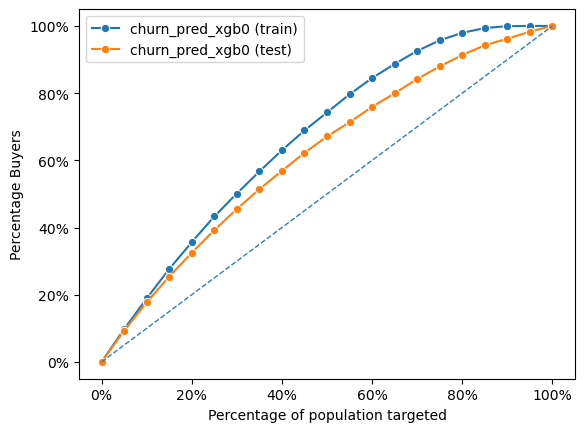

In [63]:
s_mobile_encoded_x["churn_pred_xgb0"] = xgb1.predict(s_mobile_encoded_x)['prediction']
dct_clf_xg = {"train": s_mobile_encoded_x.query("training == 1"), "test": s_mobile_encoded_x.query("training == 0")}
fig_clf_xg = rsm.gains_plot(dct_clf_xg, "churn", "yes", "churn_pred_xgb0", qnt=20)

In [64]:
param_grid_x = {
    'n_estimators': np.arange(100, 501, 100),
    'max_depth': np.arange(1,5,1),
    'learning_rate': np.arange(0.01, 0.4, 0.05),}
param_grid_x

{'n_estimators': array([100, 200, 300, 400, 500]),
 'max_depth': array([1, 2, 3, 4]),
 'learning_rate': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36])}

In [65]:
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

if os.path.exists('cv-objects/cross-validation-object_xgb1.pkl'):
    cvxgb=rsm.load_state('cv-objects/cross-validation-object_xgb1.pkl')["cv"]
else:
    stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    cvxgb=GridSearchCV(xgb1.fitted, param_grid_x, scoring = {"AUC": "roc_auc"}, cv=stratified_k_fold, n_jobs=5,refit="AUC", verbose=5).fit(xgb1.data_onehot, xgb1.data.churn)
    if not os.path.exists('cv-objects'):
        os.mkdir('cv-objects')
    rsm.save_state({"cv": cvxgb},'cv-objects/cross-validation-object_xgb1.pkl')

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:50:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738395417126/work/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [66]:
cvxgb.best_params_

{'learning_rate': 0.26, 'max_depth': 2, 'n_estimators': 500}

In [67]:
xgb2 = rsm.model.xgboost(
    {"s_mobile_xgb": s_mobile_encoded_x[s_mobile_encoded_x.training == 1]},
    rvar="churn",
    lev="yes",
    evar=evar_x,
    random_state=1234,
    **cvxgb.best_params_
)
xgb2.summary()

XGBoost
Data                 : s_mobile_xgb
Response variable    : churn
Level                : yes
Explanatory variables: changer, changem, revenue, mou, overage, roam, conference, months, uniqsubs, custcare, retcalls, dropvce, eqpdays, refurb, smartphone, highcreditr, mcycle, car, travel, region_NE, region_NW, region_SE, region_SW, occupation_professional, occupation_student, occupation_retired
Model type           : classification
Nr. of features      : (26, 26)
Nr. of observations  : 27,300
n_estimators         : 500
max_depth            : 2
min_child_weight     : 1
learning_rate        : 0.26
subsample            : 1.0
colsample_bytree     : 1.0
random_state         : 1234
AUC                  : 0.791

Estimation data      :
 changer  changem  revenue  mou  overage  roam  conference  months  uniqsubs  custcare  retcalls  dropvce  eqpdays  refurb  smartphone  highcreditr  mcycle  car  travel  region_NE  region_NW  region_SE  region_SW  occupation_professional  occupation_student  o

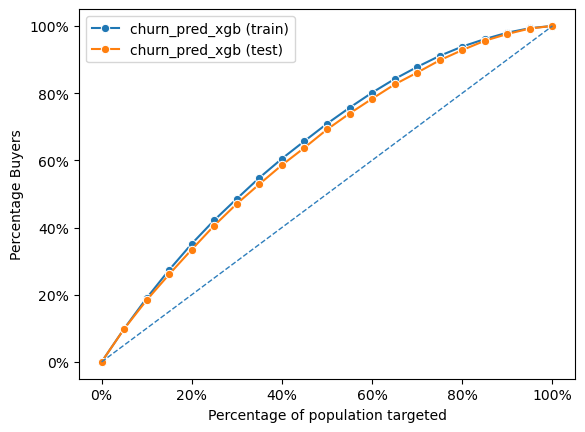

In [68]:
s_mobile_encoded_x["churn_pred_xgb"] = xgb2.predict(s_mobile_encoded_x)['prediction']
dct_clf_xg = {"train": s_mobile_encoded_x.query("training == 1"), "test": s_mobile_encoded_x.query("training == 0")}
fig_clf_xg = rsm.gains_plot(dct_clf_xg, "churn", "yes", "churn_pred_xgb", qnt=20)

In [69]:
evar_x

['changer',
 'changem',
 'revenue',
 'mou',
 'overage',
 'roam',
 'conference',
 'months',
 'uniqsubs',
 'custcare',
 'retcalls',
 'dropvce',
 'eqpdays',
 'refurb',
 'smartphone',
 'highcreditr',
 'mcycle',
 'car',
 'travel',
 'region_NE',
 'region_NW',
 'region_SE',
 'region_SW',
 'occupation_professional',
 'occupation_student',
 'occupation_retired']

In [70]:
s_mobile.columns

Index(['customer', 'churn', 'changer', 'changem', 'revenue', 'mou', 'overage',
       'roam', 'conference', 'months', 'uniqsubs', 'custcare', 'retcalls',
       'dropvce', 'eqpdays', 'refurb', 'smartphone', 'highcreditr', 'mcycle',
       'car', 'travel', 'region', 'occupation', 'training', 'representative',
       'cweight'],
      dtype='object')

In [71]:
s_mobile_encoded_x = s_mobile_encoded_x.merge(
    s_mobile[['customer', 'occupation', 'region']], 
    on='customer', 
    how='left'
)

# Display the updated dataframe
s_mobile_encoded_x.head()

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,region_NW,region_SE,region_SW,occupation_professional,occupation_student,occupation_retired,churn_pred_xgb0,churn_pred_xgb,occupation,region
0,U86940794,yes,109,81,62,600,141,0,0,8,...,0,0,0,0,0,0,0.968111,0.333767,other,CS
1,U56788559,no,0,3,54,146,0,0,0,8,...,0,1,0,0,0,0,0.841932,0.151791,other,SE
2,U47928407,no,0,-9,39,1158,96,0,1,9,...,1,0,0,1,0,0,0.983791,0.410621,professional,NW
3,U75794640,no,0,-8,35,560,0,0,0,37,...,1,0,0,0,0,1,0.102547,0.037943,retired,NW
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,0,0,1,0,0,0,0.972269,0.439956,other,SW


In [72]:
xgb3 = rsm.model.xgboost(
    {"s_mobile_xgb": s_mobile_encoded_x[s_mobile_encoded_x.training == 1]},
    rvar="churn",
    lev="yes",
    evar= ['changer',
 'changem',
 'revenue',
 'mou',
 'overage',
 'roam',
 'conference',
 'months',
 'uniqsubs',
 'custcare',
 'retcalls',
 'dropvce',
 'eqpdays',
 'refurb',
 'smartphone',
 'highcreditr',
 'mcycle',
 'car',
 'travel',
 'region','occupation'],
    random_state=1234,
    **cvxgb.best_params_
)
xgb2.summary()

XGBoost
Data                 : s_mobile_xgb
Response variable    : churn
Level                : yes
Explanatory variables: changer, changem, revenue, mou, overage, roam, conference, months, uniqsubs, custcare, retcalls, dropvce, eqpdays, refurb, smartphone, highcreditr, mcycle, car, travel, region_NE, region_NW, region_SE, region_SW, occupation_professional, occupation_student, occupation_retired
Model type           : classification
Nr. of features      : (26, 26)
Nr. of observations  : 27,300
n_estimators         : 500
max_depth            : 2
min_child_weight     : 1
learning_rate        : 0.26
subsample            : 1.0
colsample_bytree     : 1.0
random_state         : 1234
AUC                  : 0.791

Estimation data      :
 changer  changem  revenue  mou  overage  roam  conference  months  uniqsubs  custcare  retcalls  dropvce  eqpdays  refurb  smartphone  highcreditr  mcycle  car  travel  region_NE  region_NW  region_SE  region_SW  occupation_professional  occupation_student  o

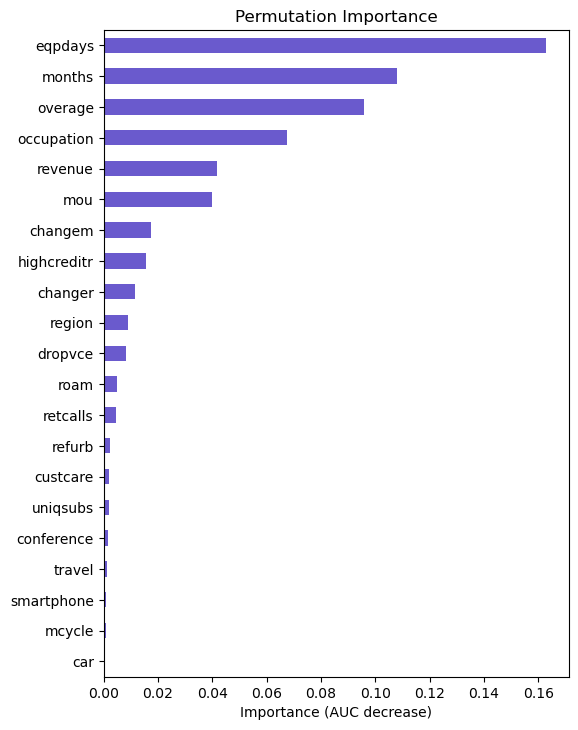

In [73]:
xgb3.plot("vimp")

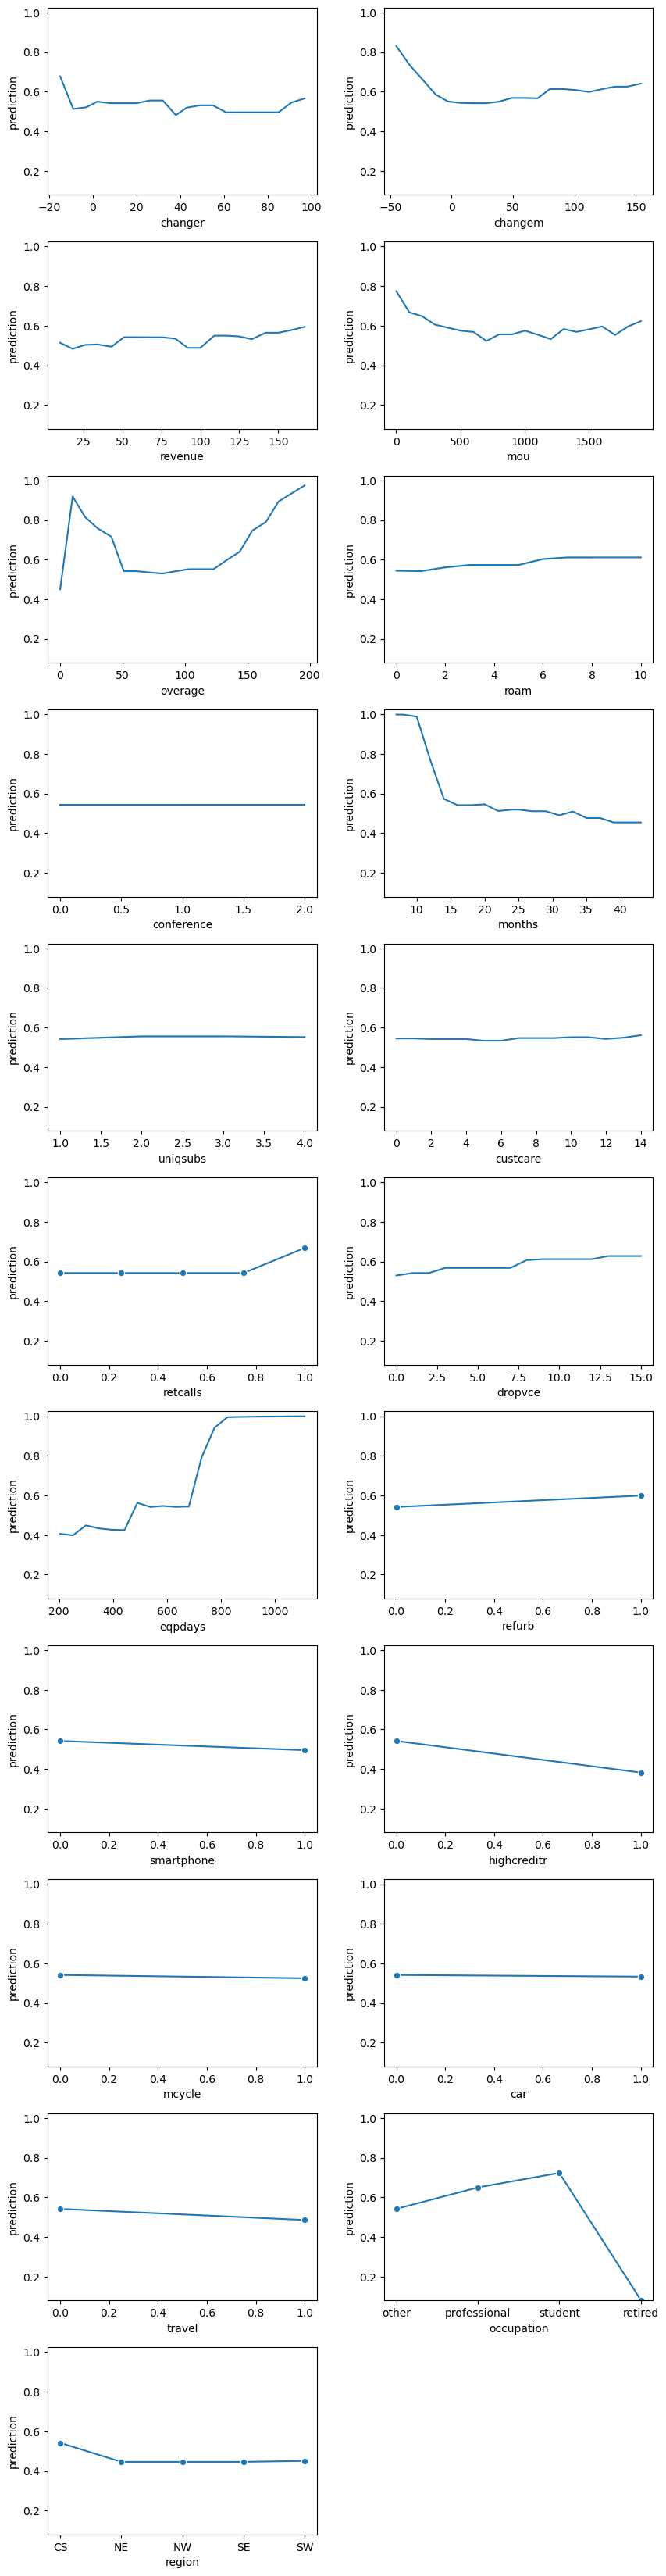

In [74]:
xgb3.plot("pred")

In [75]:
#Check avg prediction value
s_mobile_encoded_x[s_mobile_encoded_x['training'].isna()]["churn_pred_xgb"].mean()

0.39913255


The average prediction on the representative data set is much much larger than the expected 2% churn rate. 

In [76]:
#print AUC for all models

#LR
train_metrics = rsm.evalbin(s_mobile_encoded[s_mobile_encoded['training']==1], 'churn', 'yes', 'churn_pred_int', cost=1, margin=2, scale=1, dec=3)
test_metrics = rsm.evalbin(s_mobile_encoded[s_mobile_encoded['training']==0], 'churn', 'yes', 'churn_pred_int', cost=1, margin=2, scale=1, dec=3)

#NN
train_metrics_nn = rsm.evalbin(s_mobile_scaled[s_mobile_scaled['training']==1], 'churn', 'yes', 'pred_nn1', cost=1, margin=2, scale=1, dec=3)
test_metrics_nn = rsm.evalbin(s_mobile_scaled[s_mobile_scaled['training']==0], 'churn', 'yes', 'pred_nn1', cost=1, margin=2, scale=1, dec=3)

#RF
train_metrics_rf = rsm.evalbin(s_mobile_rf[s_mobile_rf['training']==1], 'churn', 'yes', 'pred_rf1', cost=1, margin=2, scale=1, dec=3)
test_metrics_rf = rsm.evalbin(s_mobile_rf[s_mobile_rf['training']==0], 'churn', 'yes', 'pred_rf1', cost=1, margin=2, scale=1, dec=3)

#XGB
train_metrics_xgb = rsm.evalbin(s_mobile_encoded_x[s_mobile_encoded_x['training']==1], 'churn', 'yes', 'churn_pred_xgb', cost=1, margin=2, scale=1, dec=3)
test_metrics_xgb = rsm.evalbin(s_mobile_encoded_x[s_mobile_encoded_x['training']==0], 'churn', 'yes', 'churn_pred_xgb', cost=1, margin=2, scale=1, dec=3)

#Datframe for AUC and avg prediction on representative data
df = pd.DataFrame(columns=['Model', 'Train AUC', 'Test AUC', 'Avg Prediction Value (%)'])
df.loc[0] = ['Logistic Regression', train_metrics['AUC'][0], test_metrics['AUC'][0], s_mobile_encoded[s_mobile_encoded['training'].isna()]['churn_pred_int'].mean() *100]
df.loc[1] = ['Neural Network', train_metrics_nn['AUC'][0], test_metrics_nn['AUC'][0], s_mobile_scaled[s_mobile_scaled['training'].isna()]['pred_nn1'].mean()*100]
df.loc[2] = ['Random Forest', train_metrics_rf['AUC'][0], test_metrics_rf['AUC'][0], s_mobile_rf[s_mobile_rf['training'].isna()]['pred_rf1'].mean()*100]
df.loc[3] = ['XGBoost', train_metrics_xgb['AUC'][0], test_metrics_xgb['AUC'][0], s_mobile_encoded_x[s_mobile_encoded_x['training'].isna()]['churn_pred_xgb'].mean()*100]
df


,Model,Train AUC,Test AUC,Avg Prediction Value (%)
0,Logistic Regression,0.689,0.694,1.986239
1,Neural Network,0.739,0.739,41.678252
2,Random Forest,0.768,0.710,2.834736
3,XGBoost,0.791,0.767,39.913255


### Estmating the models on the 1M dataset to evaluate performance

Neural Network

In [77]:
s_mobile_scaled_1M = s_mobile_1M.copy()
s_mobile_scaled_1M = rsm.scale_df(s_mobile_scaled_1M, sf=1)


s_mobile_scaled_1M = pd.get_dummies(s_mobile_scaled_1M, columns=['region', 'occupation'], drop_first=True)
bool_cols = ['region_NE', 'region_NW', 'region_SE', 'region_SW', 'occupation_professional', 'occupation_student', 'occupation_retired']
s_mobile_scaled_1M[bool_cols] = s_mobile_scaled_1M[bool_cols].astype(int)


binary_cols = ['mcycle', 'refurb', 'smartphone', 'highcreditr', 'travel', 'car']
s_mobile_scaled_1M[binary_cols] = s_mobile_scaled_1M[binary_cols].apply(lambda x: x.cat.codes)

In [78]:
nn1_1M = rsm.mlp({
    "sm_scaled1M": s_mobile_scaled_1M.query("training == 1")}, 
    rvar="churn",
    lev="yes",
    evar= evar_nn,
    mod_type="classification",
    random_state=1234,
    **cvnn.best_params_    
)

nn1_1M.summary()

Multi-layer Perceptron (NN)
Data                 : sm_scaled1M
Response variable    : churn
Level                : yes
Explanatory variables: changer, changem, revenue, mou, overage, roam, conference, months, uniqsubs, custcare, retcalls, dropvce, eqpdays, refurb, smartphone, highcreditr, mcycle, car, travel, region_NE, region_NW, region_SE, region_SW, occupation_professional, occupation_student, occupation_retired
Model type           : classification
Nr. of features      : (26, 26)
Nr. of weights       : 179
Nr. of observations  : 682,500
Hidden_layer_sizes   : (6, 2)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.706

Raw data             :
  changer   changem   revenue       mou   overage      roam  conference    months  uniqsubs  custcare  retcalls   dropvce   eqpdays  refurb  smartphone  highcreditr  mc

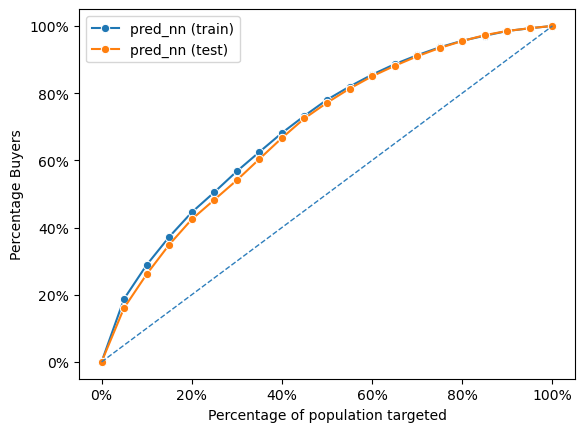

In [79]:
s_mobile_scaled_1M["pred_nn"] = nn1_1M.predict(s_mobile_scaled_1M)['prediction']
dct_clf_nn1M = {"train": s_mobile_scaled_1M.query("training == 1"), "test": s_mobile_scaled_1M.query("training == 0")}
fig_clf_nn1M = rsm.gains_plot(dct_clf_nn1M, "churn", "yes", "pred_nn", qnt=20)

Random Forest 

In [80]:
s_mobile_rf_1M = s_mobile_1M.copy()

s_mobile_rf_1M = pd.get_dummies(s_mobile_rf_1M, columns=['region', 'occupation'], drop_first=True)
bool_cols = ['region_NE', 'region_NW', 'region_SE', 'region_SW', 'occupation_professional', 'occupation_student', 'occupation_retired']
s_mobile_rf_1M[bool_cols] = s_mobile_rf_1M[bool_cols].astype(int)


binary_cols = ['mcycle', 'refurb', 'smartphone', 'highcreditr', 'travel', 'car']
s_mobile_rf_1M[binary_cols] = s_mobile_rf_1M[binary_cols].apply(lambda x: x.cat.codes)


In [81]:
rf1_1M = rsm.model.rforest(
    data ={"s_mobile_rf1M": s_mobile_rf_1M.query("training == 1")},
    rvar="churn",
    lev="yes",
    evar= evar_rf,
    random_state=1234,
    **cvrfc.best_params_
)
rf1_1M.summary()

Random Forest
Data                 : s_mobile_rf1M
Response variable    : churn
Level                : yes
Explanatory variables: changer, changem, revenue, mou, overage, roam, conference, months, uniqsubs, custcare, retcalls, dropvce, eqpdays, refurb, smartphone, highcreditr, mcycle, car, travel, region_NE, region_NW, region_SE, region_SW, occupation_professional, occupation_student, occupation_retired
OOB                  : True
Model type           : classification
Nr. of features      : (26, 26)
Nr. of observations  : 682,500
max_features         : sqrt (5)
n_estimators         : 450
min_samples_leaf     : 1
max_samples          : 0.8000000000000003
random_state         : 1234
AUC                  : 0.777
Extra arguments      : max_depth=9

Estimation data      :
 changer  changem  revenue  mou  overage  roam  conference  months  uniqsubs  custcare  retcalls  dropvce  eqpdays  refurb  smartphone  highcreditr  mcycle  car  travel  region_NE  region_NW  region_SE  region_SW  occupati

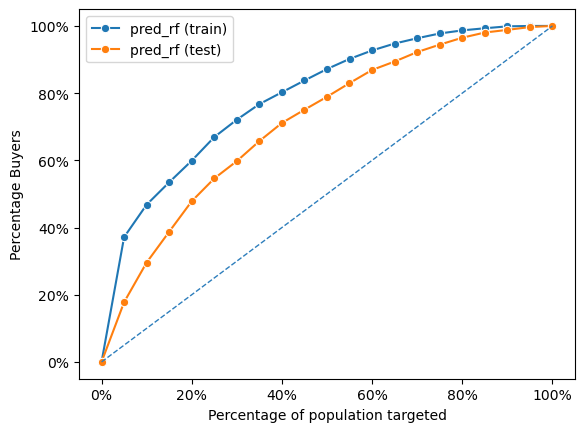

In [82]:
s_mobile_rf_1M["pred_rf"] = rf1_1M.predict(s_mobile_rf_1M)['prediction']
dct_clf_rf1M = {"train": s_mobile_rf_1M.query("training == 1"), "test": s_mobile_rf_1M.query("training == 0")}
fig_clf_rf1M = rsm.gains_plot(dct_clf_rf1M, "churn", "yes", "pred_rf", qnt=20)

XGBoost

In [83]:
s_mobile_x_1M = s_mobile_1M.copy()
binary_cols = ['mcycle', 'refurb', 'smartphone', 'highcreditr', 'travel', 'car']
s_mobile_x_1M[binary_cols] = s_mobile_x_1M[binary_cols].apply(lambda x: x.cat.codes)


In [84]:
evar_x1m = [ 'changer', 'changem', 'revenue', 'mou', 'overage',
       'roam', 'conference', 'months', 'uniqsubs', 'custcare', 'retcalls',
       'dropvce', 'eqpdays', 'refurb', 'smartphone', 'highcreditr', 'mcycle',
       'car', 'travel', 'region', 'occupation']

In [85]:
xgb2_1M = rsm.model.xgboost(
    {"s_mobile_xgb_1M": s_mobile_x_1M[s_mobile_x_1M.training == 1]},
    rvar="churn",
    lev="yes",
    evar=evar_x1m,
    random_state=1234,
    **cvxgb.best_params_
)
xgb2_1M.summary()

XGBoost
Data                 : s_mobile_xgb_1M
Response variable    : churn
Level                : yes
Explanatory variables: changer, changem, revenue, mou, overage, roam, conference, months, uniqsubs, custcare, retcalls, dropvce, eqpdays, refurb, smartphone, highcreditr, mcycle, car, travel, region, occupation
Model type           : classification
Nr. of features      : (21, 28)
Nr. of observations  : 682,500
n_estimators         : 500
max_depth            : 2
min_child_weight     : 1
learning_rate        : 0.26
subsample            : 1.0
colsample_bytree     : 1.0
random_state         : 1234
AUC                  : 0.789

Estimation data      :
 changer  changem  revenue  mou  overage  roam  conference  months  uniqsubs  custcare  retcalls  dropvce  eqpdays  refurb  smartphone  highcreditr  mcycle  car  travel  region_CS  region_NE  region_NW  region_SE  region_SW  occupation_other  occupation_professional  occupation_student  occupation_retired
       0       -2       87  412      1

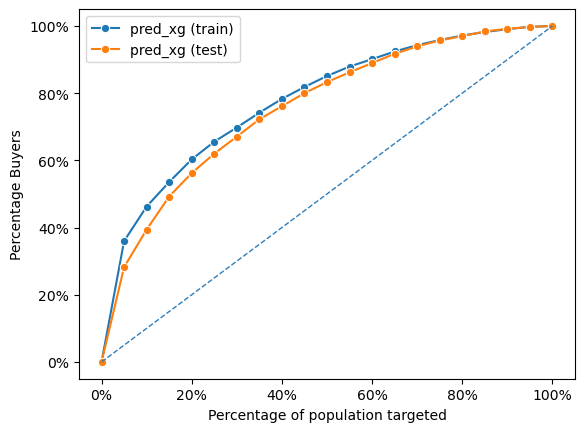

In [86]:
s_mobile_x_1M["pred_xg"] = xgb2_1M.predict(s_mobile_x_1M)['prediction']
dct_clf_xgb1M = {"train": s_mobile_x_1M.query("training == 1"), "test": s_mobile_x_1M.query("training == 0")}
fig_clf_xgb1M = rsm.gains_plot(dct_clf_xgb1M, "churn", "yes", "pred_xg", qnt=20)

Final comparison of models

In [87]:
#print AUC for all models 

#LR
train_metrics_1 = rsm.evalbin(s_mobile_encoded[s_mobile_encoded['training']==1], 'churn', 'yes', 'churn_pred_int', cost=1, margin=2, scale=1, dec=3)
test_metrics_1 = rsm.evalbin(s_mobile_encoded[s_mobile_encoded['training']==0], 'churn', 'yes', 'churn_pred_int', cost=1, margin=2, scale=1, dec=3)
avg_lr_1 = s_mobile_encoded[s_mobile_encoded['training'].isna()]['churn_pred_int'].mean()

#NN
train_metrics_nn_1 = rsm.evalbin(s_mobile_scaled_1M[s_mobile_scaled_1M['training']==1], 'churn', 'yes', 'pred_nn', cost=1, margin=2, scale=1, dec=3)
test_metrics_nn_1 = rsm.evalbin(s_mobile_scaled_1M[s_mobile_scaled_1M['training']==0], 'churn', 'yes', 'pred_nn', cost=1, margin=2, scale=1, dec=3)
avg_nn_1 = s_mobile_scaled_1M[s_mobile_scaled_1M['training'].isna()]['pred_nn'].mean()

#RF
train_metrics_rf_1 = rsm.evalbin(s_mobile_rf_1M[s_mobile_rf_1M['training']==1], 'churn', 'yes', 'pred_rf', cost=1, margin=2, scale=1, dec=3)
test_metrics_rf_1 = rsm.evalbin(s_mobile_rf_1M[s_mobile_rf_1M['training']==0], 'churn', 'yes', 'pred_rf', cost=1, margin=2, scale=1, dec=3)
avg_rf_1 = s_mobile_rf_1M[s_mobile_rf_1M['training'].isna()]['pred_rf'].mean()

#XGB
train_metrics_xgb_1 = rsm.evalbin(s_mobile_x_1M[s_mobile_x_1M['training']==1], 'churn', 'yes', 'pred_xg', cost=1, margin=2, scale=1, dec=3)
test_metrics_xgb_1 = rsm.evalbin(s_mobile_x_1M[s_mobile_x_1M['training']==0], 'churn', 'yes', 'pred_xg', cost=1, margin=2, scale=1, dec=3)
avg_xgb_1 = s_mobile_x_1M[s_mobile_x_1M['training'].isna()]['pred_xg'].mean()


#Datframe for AUC and avg prediction on representative data
df1 = pd.DataFrame(columns=['Model', 'Train AUC', 'Test AUC', 'Avg Prediction Value (%)'])
df1.loc[0] = ['Logistic Regression', train_metrics_1['AUC'][0], test_metrics_1['AUC'][0], avg_lr_1 *100]
df1.loc[1] = ['Neural Network', train_metrics_nn_1['AUC'][0], test_metrics_nn_1['AUC'][0], avg_nn_1 *100]
df1.loc[2] = ['Random Forest', train_metrics_rf_1['AUC'][0], test_metrics_rf_1['AUC'][0], avg_rf_1 *100]
df1.loc[3] = ['XGBoost', train_metrics_xgb_1['AUC'][0], test_metrics_xgb_1['AUC'][0], avg_xgb_1 *100]
df1




/home/jovyan/.rsm-msba/lib/python3.12/site-packages/pyrsm/model/perf.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
/home/jovyan/.rsm-msba/lib/python3.12/site-packages/pyrsm/model/perf.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


,Model,Train AUC,Test AUC,Avg Prediction Value (%)
0,Logistic Regression,0.689,0.694,1.986239
1,Neural Network,0.706,0.694,2.077546
2,Random Forest,0.803,0.720,2.552297
3,XGBoost,0.789,0.766,2.300503


After estimating the average churn probability on the 1M dataset based on our models tuned on the 50-50 data, we observe that the XGboost model seems to be the best choice as it has a good fit for train and test data (1M), the best AUC (train: 0.789, test: 0.766) and has an average prediction probability on the representative sample (1M) of 2.3% which is close to the actual churn percentage of 2%.


2. Main drivers of churn and the key factors that predict 
customer churn and their relative importance. 


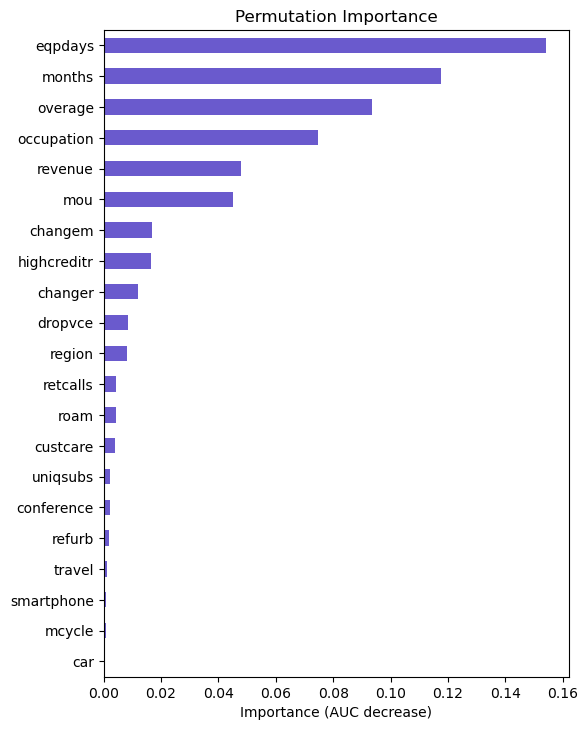

In [88]:
xgb2_1M.plot("vimp")


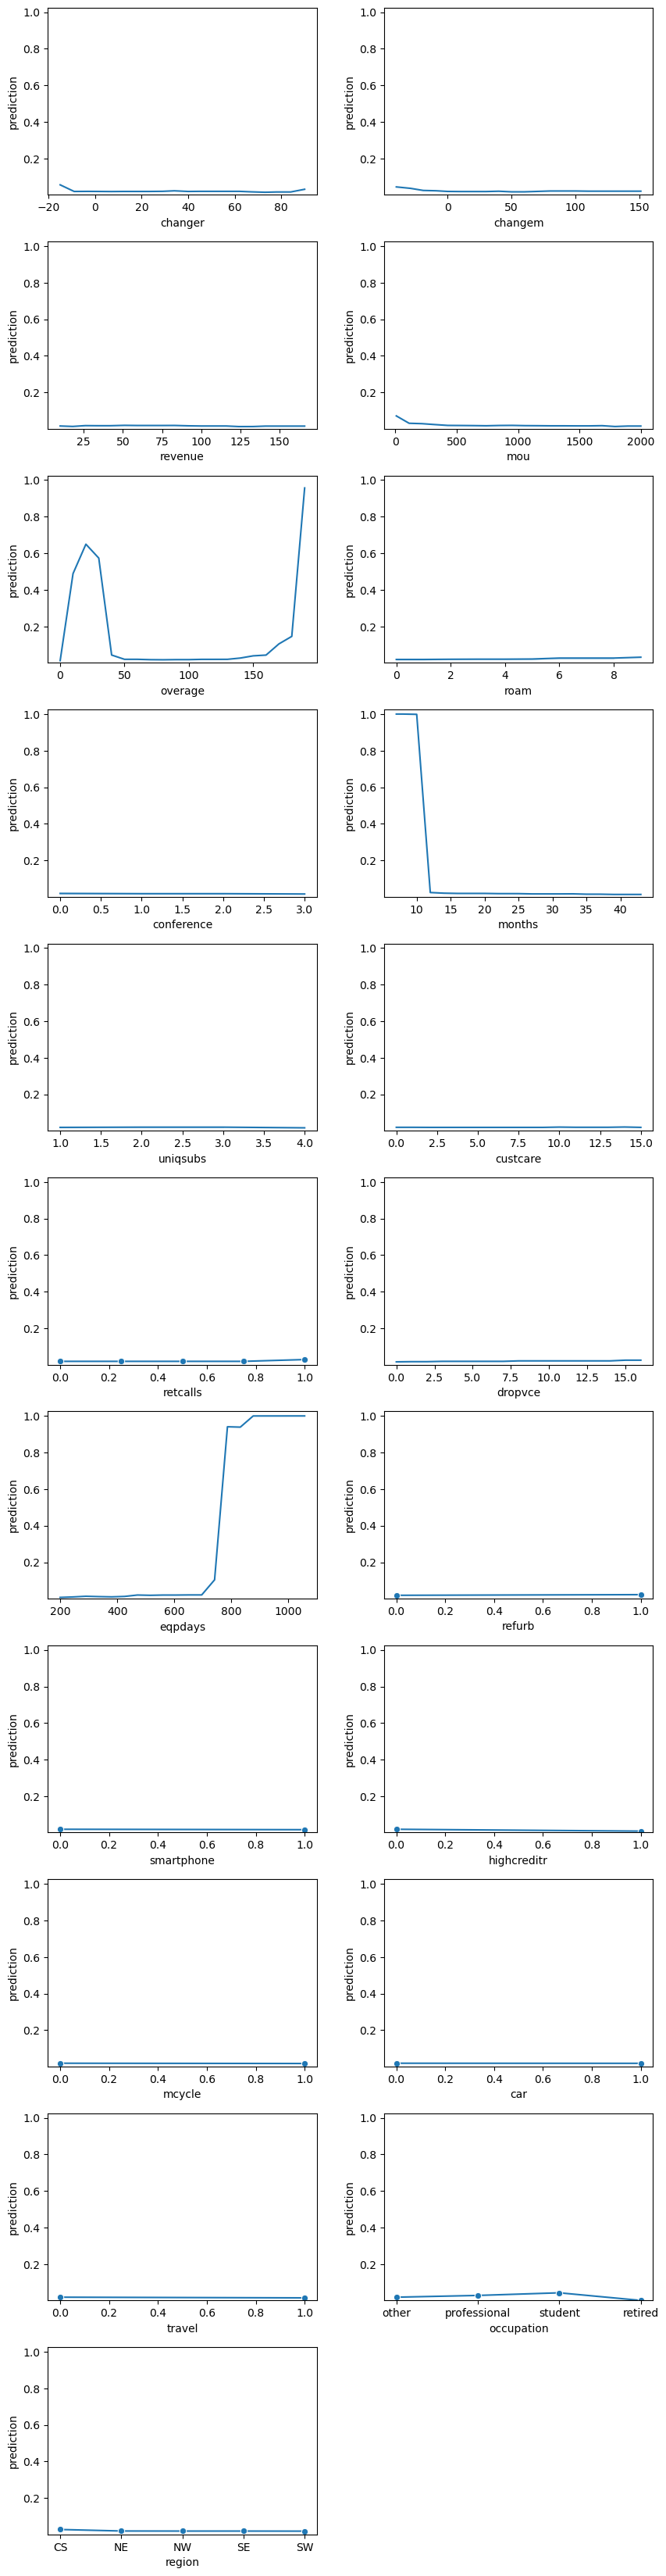

In [89]:
xgb2_1M.plot('pred')

In [90]:
s_mobile['occupation'].unique()
s_mobile['occupation'].value_counts()

occupation
other           43366
professional    13506
retired          7485
student          4643
Name: count, dtype: int64

**Key Drivers of Customer Churn in S-Mobile as XGBoost Model**
The Permutation Importance plot and Prediction Plots provide insights into the most influential factors driving churn. Based on the permutation importance plot, the decrease in AUC when shuffling the variables is greatest for "eqpdays," followed by "months," "overage," "occupation," and "revenue," keeping all else constant. The prediction plots show increasing churn probabilities for higher "overage" charges and longer "eqpdays" (keeping all else constant), indicating that customers with higher excess usage fees and older devices are more likely to churn. "Months" shows a decreasing trend, suggesting that long-tenured customers are less likely to churn, with a sharp decline in churn probability after 12 months, keeping all else constant. The "occupation" plot reveals significant variability, with students and professionals having the highest churn rates, while retired individuals are the least likely to churn, keeping all else constant. The "revenue" plot shows that low-revenue customers have the highest churn rates, whereas moderate-to-high revenue customers exhibit lower churn probabilities, keeping all else constant.

The five key drivers of churn are:


1. Eqpdays  (Number of days customer has owned current handset):
  - The Permutation Importance plot ranks eqpdays as the top driver of churn.
  - Customers using older or refurbished devices are more likely to churn, possibly due to performance issues or lack of new features keeping all else constant.
  - The Prediction plot reveals a sharp increase in churn probability after 600-700 days, keeping all else constant.
- Recommendation:
  - Implement an early upgrade program to encourage customers to replace aging devices before dissatisfaction leads to churn, perhaps focusing on a targeted upgrade program for customers whose devices are over 600 days old.
  - Offer discounted trade-in options or installment plans for new devices.

2. Months (# of months the customer has had service):
  - The Permutation Importance plot ranks months as the second most important churn predictor.
  - It seems like the longer a customer stays with S-Mobile, the lower their churn probability, keeping all else constant.
  - The Prediction plot shows a significant drop in churn probability after approx 12 months, keeping all else constant.
  - New customers (less than 12 months) are at the highest risk of leaving, keeping all else constant, likely due to initial dissatisfaction or better competitor deals.
- Recommendation:
  - Introduce personalized rewards, discounts etc. for new customers to incentivize retention in the first 12 months.

3. Overage (Mean monthly overage minutes):
  - The Permutation Importance plot ranks overage among the top three drivers.
  - At very low overage amounts (0-25), there is a spike in churn probability, keeping all else constant.
  - High overage fees likely lead to customer dissatisfaction and search for better plans, keeping all else constant.
  - The Prediction plot shows a notable spike in churn probability when overage surpasses 150 minutes, keeping all else constant.
  - It seems like in general, overage causes the customers to churn, perhaps as they may want to look for more affordable plans, that suit their usage needs, without incurring unexpected fees/charges. However, there is a drop in the churn probability for customers with overage minutes between 25-150, keeping all else constant, perhaps because they are willing to pay a little extra for the convenience of not having to worry about exceeding their limits or may have other discounts or loyalty towards the brand.
- Recommendation:
  - Introduce real-time usage alerts and usage caps to notify customers before they exceed their limits.
  - Offer personalized plan upgrades for heavy users, that are more affordable than competitors. 
  - Implement "Overage Forgiveness" for loyal customers who exceed overage by a slight amount (0-25 min)

4. Occupation (Type of occupation of the customer):
  - The Permutation Importance plot highlights occupation as a key churn predictor.
  - Students and professionals have higher churn rates, while retired individuals are the least likely to churn, keeping all else constant as per prediction plots. It seems like students and professionals are more likely to churn due to lifestyle changes (e.g., relocation, financial instability), keeping all else constant. Seniors may be less likely to churn due to comfort with the service or less interest in switching providers.
- Recommendation:
  - Create tailored retention strategies for students and professionals, such as flexible payment plans or exclusive discounts, or tie ups with their instititutions or corporate.
  - Offer loyalty rewards or discounts for retired individuals to incentivize long-term commitment.

5. Revenue (Mean monthly revenue in SGD):
  - The Permutation Importance plot ranks revenue as a key churn predictor, 5th from the top, but prediction plots show that change in revenue does not change probability of churn much, keeping all else constant.
  - The Prediction plot shows a very minimal decline in churn probability as revenue increases, keeping all else constant. It seems like customers with higher revenue are not as money-conscious, less price-sensitive or may be more loyal to the brand, and are less likely to churn.
- Recommendation:
  - Offer low-cost, flexible retention plans for low-revenue customers.



3. Use insights on churn drivers to develop actions/offers/incentives
 

*Eqpdays:*
Data Insights: The mean is 424 days (~14 months), with 75% of customers having devices older than 516 days (~1.7 years). Some customers have very old devices, with the max being close to 4.7 years. Churn rate is 2.56% when eqpays > 600, and 1.78% otherwise.

Prediction Plot Insights: Churn probability rises sharply after ~600 days, indicating that customers with older devices are significantly more likely to leave, likely in search of an upgrade. Offering early device trade-in discounts or financing options before they reach this threshold could reduce churn risk.

Strategy: Many high-value customers have aging devices, meaning they are ripe for an upgrade offer.
Customers with very old devices might churn if a competitor offers a better upgrade deal.

Offering discounted upgrades or extended warranties can improve retention.
From the prediction plot for this variable, we see that older devices (older than 600) show a sharp increase in churn probability likely due to the outdated technology. 
Therefore, early upgrade incentives should aid with churn and these should be offered to customers a month before their device reaches 700 days.

*Occuptation*

Data Insights: Professionals have a churn rate of 2.87% and the students have a churn rate of 3.68%.
Professionals stay the longest - their average tenure is 19.87 months, while students stay 19.5 months on an average. 

Prediction Plot Insights: Students exhibit a higher churn probability, while retirees have the lowest churn, suggesting that students may need flexible, budget-friendly plans, whereas retirees are more stable customers. Targeted retention strategies such as discounted student plans and premium perks for professionals could be effective.

Strategy: Students and professionals receive customized retention plans like discounts, cheaper student plans, business plan bundles, or premium support. 

*dropVCE*
Data Insight: Most customers experience minimal dropped calls, 25% don't experience this at all. The 75th percentile is at 4 dropped calls, but the maximum reaches 111, meaning that some users face extreme network reliability issues. These high-drop-call users are prime candidates for network-related churn and should be targeted for service recovery efforts. Customers who have a positive number of drops have a churn rate of 1.94%.

Prediction Plot Insights: Churn increases steadily as dropped calls rise above 0, confirming that poor network reliability directly leads to customer dissatisfaction and churn. Providing network improvement guarantees, priority troubleshooting, or service credits for affected customers could improve retention.

Strategy: Offer bill credits of 10 dollars as compensation for inconvenience caused by drops.

*months*

Data Insights: Most customers are relatively new, with a median tenure of 16 months and 25% staying for less than 11 months, making early-stage churn a key risk that requires proactive engagement. Customers who have been subscribed for <10 months have a churn rate of 0.96% . Churn may also spike at the 2-year mark (24 months), indicating the need for contract renewal incentives to retain customers. With tenure ranging from 6 to 61 months, a dual strategy of early engagement for new users and loyalty rewards for long-term customers can help optimize retention.

Prediction Plot Insights: Churn is highest for customers in their first year (<12 months) and declines significantly after 20+ months, highlighting that early engagement strategies are crucial. Offering welcome bonuses, onboarding support, and retention incentives at contract renewal periods (e.g., 24 months) can help retain customers.

Strategy: Onboarding Rewards for New Customers.
Offer bonus data/minutes to new users to increase engagement.Reward 3+ year customers with exclusive benefits to retain them.

*changem*

Data Insights: The median change in usage (changem) is -1, meaning that half of the customers have reduced their usage, with 25% experiencing a significant drop of more than -9 minutes, indicating a potential churn risk. The high standard deviation (51.4) and wide range (-78 to 540) suggest that customer behavior varies greatly, with some users increasing usage significantly while others disengage. Targeted interventions such as personalized recommendations, usage-based incentives, or engagement campaigns can help retain customers who show declining usage trends. Those with a decrease (-ve) change in minutes have a churn rate of 2.16%.

Prediction Plot Insights: Customers with a decline in usage (negative changem) have a significantly higher churn probability, signaling that disengagement is an early warning sign. Proactive engagement strategies, such as usage-based rewards or personalized plan recommendations, can help reactivate low-engagement users and prevent churn.

Strategy: Receive personalized engagement emails or plan optimization recommendations to promote their increment in talk time.

Specific prompts given to chatgpt (detailed screenshots can be found in GenAI document):
- Brainstorm ideas on actions that will help reduce churn for eqpdays, occupation = student,professional, dropvce, months, and changem, given the data description
- Which strategies will be the most impactful and why?
- Why does a decrease in minutes used cause a higher churn?
- Are rewards for non-churners better than incentives for churners?



4. Quantify the impact of these (5) actions/offers/incentives on the probability of churn based on whether we can (i) predict the effect of a churn driver (similar to what we did for Pentathlon NPTB) or (ii) suggest how we might set up an experiment (RCT) to evaluate the action/incentive/offer in the field 


In [91]:

#1
# Binning overage
# Quartiles
bins = [0, 40, 127, 283]  # 0-40 (low), 41-127 (medium), 128+ (high)
labels = ['Low Overage', 'Medium Overage', 'High Overage']

# Apply binning
s_mobile['overage_category'] = pd.cut(s_mobile['overage'], bins=bins, labels=labels, include_lowest=True)

# Check category distribution
print(s_mobile['overage_category'].value_counts())

# Describe eqpdays variable
print(s_mobile['eqpdays'].describe())




#2
# Define bins based on quartiles
bins = [0, 365, 550, 750, 1982]  # New: <1 year, Mid: 1-1.5 years, Old: 1.5-2 years, Very Old: >2 years
labels = ['New Device', 'Mid-Age Device', 'Old Device', 'Very Old Device']

# Apply binning
s_mobile['device_age_category'] = pd.cut(s_mobile['eqpdays'], bins=bins, labels=labels, include_lowest=True)

# Check distribution
print(s_mobile['device_age_category'].value_counts())

# Display top 10 highest-value customers by revenue
top_customers = s_mobile.sort_values(by='revenue', ascending=False).head(10)
print(top_customers[['customer', 'revenue', 'mou', 'overage', 'eqpdays']])



#3
# Count customers for each specific occupation category
num_professionals = (s_mobile['occupation'] == 'professional').sum()
num_students = (s_mobile['occupation'] == 'student').sum()
num_retired = (s_mobile['occupation'] == 'retired').sum()
num_other = (s_mobile['occupation'] == 'other').sum()

# Print the results
print(f"Number of Professionals: {num_professionals}")
print(f"Number of Students: {num_students}")
print(f"Number of Retired: {num_retired}")
print(f"Number of Other: {num_other}")

# Describe overage variable
print(s_mobile['overage'].describe())



#4
# Calculate the 90th percentile for revenue
high_value_threshold = s_mobile['revenue'].quantile(0.90)

# Identify high-value customers
high_value_customers = s_mobile[s_mobile['revenue'] >= high_value_threshold]

# Display count and threshold
print(f"High-Value Customer Threshold: {high_value_threshold:.2f}")
print(f"Number of High-Value Customers: {len(high_value_customers)}")

# Summary statistics of high-value customers
print(high_value_customers[['revenue', 'mou', 'overage', 'eqpdays']].describe())

#5
import pandas as pd

# Define high-value threshold (top 10% revenue percentile)
high_value_threshold = s_mobile['revenue'].quantile(0.90)

# Segment customers
high_value_customers = s_mobile[s_mobile['revenue'] >= high_value_threshold]
regular_customers = s_mobile[s_mobile['revenue'] < high_value_threshold]

# Compute average stats for both groups
comparison = pd.DataFrame({
    'Metric': ['Revenue', 'Minutes of Use (MOU)', 'Overage Minutes', 'Device Age (eqpdays)'],
    'High-Value Customers': [
        high_value_customers['revenue'].mean(),
        high_value_customers['mou'].mean(),
        high_value_customers['overage'].mean(),
        high_value_customers['eqpdays'].mean()
    ],
    'Regular Customers': [
        regular_customers['revenue'].mean(),
        regular_customers['mou'].mean(),
        regular_customers['overage'].mean(),
        regular_customers['eqpdays'].mean()
    ]
})

# Display results
print(comparison)


#6
# Compute percentiles for revenue, MOU, overage, and device age
percentiles = [0.25, 0.50, 0.75, 0.90]

# Apply percentile calculations
percentile_values = s_mobile[['revenue', 'mou', 'overage', 'eqpdays']].quantile(percentiles)

# Print results
print(percentile_values)

# Define high-risk customers based on overage, device age, and retention calls
high_risk_customers = s_mobile[
    (s_mobile['overage'] > s_mobile['overage'].quantile(0.75)) &
    (s_mobile['eqpdays'] > s_mobile['eqpdays'].quantile(0.75)) &
    (s_mobile['retcalls'] > s_mobile['retcalls'].quantile(0.75))
]

# Print number of high-risk customers
print(f"Number of high-risk customers: {len(high_risk_customers)}")

# Show a sample of high-risk customers
print(high_risk_customers[['customer', 'overage', 'eqpdays', 'retcalls', 'churn']].head(10))


overage_category
Low Overage       34662
Medium Overage    17281
High Overage      17057
Name: count, dtype: int64
count    69000.000000
mean       526.235696
std        230.014550
min         11.000000
25%        367.000000
50%        480.000000
75%        648.000000
max       1982.000000
Name: eqpdays, dtype: float64
device_age_category
Mid-Age Device     26748
New Device         17058
Old Device         14009
Very Old Device    11185
Name: count, dtype: int64
        customer  revenue   mou  overage  eqpdays
45405  U15064662     1223  4304      168    548.0
24505  U88638131      861   951        0    384.0
57583  U60458105      856  4034      197    263.0
54754  U73730852      848  1731      236    377.0
6502   U36584715      793  4661      271    548.0
8360   U66738310      776  3978      262    406.0
65618  U51014365      758  2479      246    460.0
56176  U67602896      648  3120      265    664.0
64364  U73441045      630  3129       75    322.0
27221  U47939408      626  2858  

In [92]:
s_mobile_x_1M["churn_yes"] = rsm.ifelse(s_mobile_x_1M.churn == "yes", 1, 0)
s_mobile_x_1M_rep = s_mobile_x_1M.query("representative == 1").copy()
s_mobile_x_1M_rep["p_eqpdays800"] = xgb2_1M.predict(s_mobile_x_1M_rep.assign(eqpdays=600))["prediction"]
eqptable = s_mobile_x_1M_rep.loc[s_mobile_x_1M_rep.eqpdays > 600, ["churn_yes", "p_eqpdays800"]].agg(["count", "mean"]).round(4)
eqptable

,churn_yes,p_eqpdays800
count,8270.0000,8270.0000
mean,0.0258,0.0254


In [93]:
s_mobile_x_1M["churn_yes"] = rsm.ifelse(s_mobile_x_1M.churn == "yes", 1, 0)
s_mobile_x_1M_rep = s_mobile_x_1M.query("representative == 1").copy()
s_mobile_x_1M_rep["p_dropvce0"] = xgb2_1M.predict(s_mobile_x_1M_rep.assign(dropvce=0))["prediction"]
dropvcetable7 = s_mobile_x_1M_rep.loc[s_mobile_x_1M_rep.dropvce == 0, ["churn_yes", "p_dropvce0"]].agg(["count", "mean"]).round(4)
dropvcetable7

,churn_yes,p_dropvce0
count,8766.0000,8766.000
mean,0.0226,0.024


In [94]:
#month
s_mobile_x_1M["churn_yes_months_greaterthan10"] = rsm.ifelse(s_mobile_x_1M.churn == "yes", 1, 0)
s_mobile_x_1M_rep = s_mobile_x_1M.query("representative == 1").copy()
s_mobile_x_1M_rep["p_months0"] = xgb2_1M.predict(s_mobile_x_1M_rep.assign(months=0))["prediction"]
monthtable13 = s_mobile_x_1M_rep.loc[ s_mobile_x_1M_rep.months > 10, ["churn_yes_months_greaterthan10", "p_months0"]].agg(["count", "mean"]).round(4)
monthtable13

,churn_yes_months_greaterthan10,p_months0
count,22790.0000,22790.0000
mean,0.0228,0.6742


In [95]:
#changem
s_mobile_x_1M["churn_yes_changem"] = rsm.ifelse(s_mobile_x_1M.churn == "yes", 1, 0)
s_mobile_x_1M_rep = s_mobile_x_1M.query("representative == 1").copy()
s_mobile_x_1M_rep["p_changem0"] = xgb2_1M.predict(s_mobile_x_1M_rep.assign(changem= 0))["prediction"]
changemtable = s_mobile_x_1M_rep.loc[s_mobile_x_1M_rep.changem < 0, ["churn_yes_changem", "p_changem0"]].agg(["count", "mean"]).round(4)
changemtable

,churn_yes_changem,p_changem0
count,14905.0000,14905.0000
mean,0.0221,0.0207


In [96]:
import pandas as pd

# Create an empty list to store results
results = []

occupations = list(s_mobile_x_1M["occupation"].unique())
for occu in occupations:
 
    # Create churn binary variable
    churn_col = "churn_yes_" + occu
    pred_col = "p_" + occu + "_all"
    
    s_mobile_x_1M[churn_col] = rsm.ifelse(s_mobile_x_1M.churn == "yes", 1, 0)
    s_mobile_x_1M_rep = s_mobile_x_1M.query("representative == 1").copy()
    
    # Predict churn probability by setting occupation to the current category
    s_mobile_x_1M_rep[pred_col] = xgb2_1M.predict(s_mobile_x_1M_rep.assign(occupation=occu))["prediction"]
    
    # Compute count and mean
    agg_results = s_mobile_x_1M_rep.loc[:, [churn_col, pred_col]].agg(["count", "mean"]).round(4)
    
    # Append results to list
    results.append({
        "variable": churn_col,
        "count": agg_results.loc["count", churn_col],
        "mean": agg_results.loc["mean", churn_col]
    })
    
    results.append({
        "variable": pred_col,
        "count": agg_results.loc["count", pred_col],
        "mean": agg_results.loc["mean", pred_col]
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
results_df


,variable,count,mean
0,churn_yes_other,30000.0,0.0200
1,p_other_all,30000.0,0.0236
2,churn_yes_student,30000.0,0.0200
3,p_student_all,30000.0,0.0437
4,churn_yes_retired,30000.0,0.0200
5,p_retired_all,30000.0,0.0047
6,churn_yes_professional,30000.0,0.0200
7,p_professional_all,30000.0,0.0356


1. Equipment Days (p_eqpdays0 = 0.0254, Mean Churn = 0.0258)
When looking at the churn probability increment for customers with 600 equipment days (0.0254) and > 600 eqpdays (0.0258) (when a sharp increase is observed in plots) is not very different either. However, there might be a possibility eqpdays could still be correlated with churn indirectly.

2. Occupation (p_all set to students = 0.0437, p__all set to retired = 0.0047, p__all set to professional = 0.0356, p__all set to other = 0.0236, Mean churn = 0.02)
Customers who are students and working professionals seems to have a much higher churn than the mean of 2%. Retired users seem to have the least probability of churn. We must focus on engaging students and working professionals better to reduce churn.

3. Subscription Duration (p_months0 = 67.42%, Mean Churn for >10 m customers = 2.28%)
Customers with less than 10 active months (i.e., seasoned subscribers) have a higher churn probability compared to overall mean for those who have been subscribed for more than 10 months (2.28%).
Interpretation: New users have the highest risk for churn.

4. Change in minutes (p_changem0 = 0.0207, Mean Churn = 0.0221)
Customers who decrease their minutes of use to a lower amount have a higher churn probability (2.21%) than the those who do not change or increase their minutes of usage (2.07%).
Insight: When customers start using fewer minutes, it often means they no longer see as much value in the service, and may want to churn.

5. dropvce (p_dropvce0 = 0.024, Mean Churn = 0.0226)
Customers who have experienced dropped calls have a mean churn probability of 2.4%, which is greater than the mean churn probability (2.26%) for those who haven't experience dropped calls.
Interpretation : Customers who experience poor network quality (frequent dropped calls) are more likely to churn.
These users may be passively churning because they are not utilizing the service much, rather than actively dissatisfied with it.

Experimental Design
Since a real-world randomized controlled trial (RCT) is not feasible, we propose to evaluate the impact of different strategies based on our churn model.

*Step 1: Define Experimental Groups*

- Device Age (eqpdays) Intervention:
Treatment Group: Customers with eqpdays > 600 receive early upgrade offers, such as discounted device upgrades, extended warranties, or free accessories.
Control Group: Similar customers receive no upgrade incentives.
Rationale: While eqpdays alone shows minimal impact on churn, offering upgrade incentives can improve customer retention and satisfaction.

- Occupation-Based Targeting:
Treatment Group: Students and professionals receive customized retention plans, including cheaper student plans, business plan bundles, or premium support.
Control Group: Similar customers receive no specialized offer.
Rationale: Students and professionals have a significantly higher churn probability than the mean, requiring targeted retention efforts. Retired users, with much lower churn probability, do not need aggressive retention strategies.

- Dropped Calls (dropvce) Reduction:
Treatment Group: Customers experiencing dropped calls receive network improvement rebates, apology credits, or $10 bill compensation.
Control Group: No intervention.
Rationale: Poor network quality is associated with a higher churn probability, so compensating affected customers or improving service quality can help mitigate churn.

- Tenure-Based Loyalty Rewards (months):
Treatment Group: Customers within their first 10 months receive bonus data, one-time bill discounts, or a 3-month bonus data plan.
Control Group: No additional incentives.
Rationale: New customers (<13 months) churn at a higher rate than average, indicating that early engagement incentives can improve retention.

- Usage Trend (changem) Adjustment:
Treatment Group: Customers who decrease their usage receive personalized engagement emails or plan optimization recommendation (eg: lower tier plan)
Control Group: No intervention.
Rationale: If customers are reducing usage due to cost concerns, offering a better-suited plan can prevent them from canceling entirely. Helps customers feel in control of their spending, reducing churn due to pricing dissatisfaction.



*Step 2: Metrics for Evaluation*
We track the following Key Performance Indicators (KPIs) to measure the success of interventions:
- Churn Rate (%) – Reduction in churn probability compared to the control group.
- Customer Lifetime Value (CLV) – Impact of interventions on long-term revenue.
- Offer Redemption Rate (%) – Percentage of customers who accepted the retention offer.
- Customer Satisfaction (CSAT) – Feedback from customers in the treatment group.

More specific to our variables, metrics to look into:
- % customers that got a new device as per upgrade incentive offered before 600 days reached
- %student and professionals accepted offered discount and long terms plans to prevent churn
- %reduction on dropped calls, %customers incentivized by compensation and utilized it to extend plan


Intervention - Expected Reduction (%)

- Device Upgrade (eqpdays) - 1.57% decrease
- Occupation-Based Offer(student) - 118.5% decrease
- Occupation-Based Offer(professionals) - 78% decrease
- Dropped Call Compensation(dropvce) - 6.19% decrease 
- Loyalty Rewards (months) - 96.6% increase 
- Usage Decline (changem) - 6.76% increase

*Step 3: Assumptions on Expected Results*

- Customers who accept retention offers should show lower churn probability than those in the control group.
- Loyalty rewards and occupation-based offers are expected to have the strongest impact, as they target high-risk customer segments.
- Network compensation and device upgrades may lower churn and can improve customer satisfaction and reduce dissatisfaction-driven churn.


This experiment allows us to simulate real-world interventions and project impact on churn using existing prediction data. This approach provides a structured approach to testing customer retention strategies.


5. Decide which of the 5 actions/offers/incentives to target to which customers 
• For each action/offer/incentive specify the criteria used to select customers. 

1. **Equipment Age (eqpdays) Intervention**  
   - **Target Group**: Customers with eqpdays > 600  
   - **Justification**: Older devices may cause dissatisfaction, leading to churn. Offering discounted upgrades or extended warranties can improve retention.
   - **Application**: Only to a subset, as not all customers have older devices.

In [97]:
# subset to apply treatment to

s_mobile_1M_treateqp = s_mobile_1M[s_mobile_1M['eqpdays' ] > 600]
print(s_mobile_1M_treateqp[s_mobile_1M_treateqp['churn'] == 'yes'].shape[0])
print(s_mobile_1M_treateqp[s_mobile_1M_treateqp['churn'] == 'no'].shape[0])


7184
272990


In [98]:
# Split the DataFrame into two groups based on the churn column
group_yes = s_mobile_1M_treateqp[s_mobile_1M_treateqp['churn'] == 'yes']
group_no = s_mobile_1M_treateqp[s_mobile_1M_treateqp['churn'] == 'no']

# Determine the minimum number of samples in each group
min_samples_yes = len(group_yes) // 2
min_samples_no = len(group_no) // 2

# Randomly sample the minimum number of samples from each group for group_a
group_a_yes = group_yes.sample(n=min_samples_yes, random_state=1234)
group_a_no = group_no.sample(n=min_samples_no, random_state=1234)

# Create group_a by combining the sampled groups
group_a = pd.concat([group_a_yes, group_a_no])

# Create group_b by taking the remaining samples
group_b_yes = group_yes.drop(group_a_yes.index)
group_b_no = group_no.drop(group_a_no.index)

# Combine the remaining samples to create group_b
group_b = pd.concat([group_b_yes, group_b_no])

# Display the number of samples in each group
print(f"Group A (churn == yes): {len(group_a_yes)} samples")
print(f"Group A (churn == no): {len(group_a_no)} samples")
print(f"Group B (churn == yes): {len(group_b_yes)} samples")
print(f"Group B (churn == no): {len(group_b_no)} samples")

Group A (churn == yes): 3592 samples
Group A (churn == no): 136495 samples
Group B (churn == yes): 3592 samples
Group B (churn == no): 136495 samples


In [99]:
s_mobile_1M.columns

Index(['customer', 'churn', 'changer', 'changem', 'revenue', 'mou', 'overage',
       'roam', 'conference', 'months', 'uniqsubs', 'custcare', 'retcalls',
       'dropvce', 'eqpdays', 'refurb', 'smartphone', 'highcreditr', 'mcycle',
       'car', 'travel', 'region', 'occupation', 'training', 'representative'],
      dtype='object')

In [100]:
# Display the first few rows of each group
print("Group A:")
print(group_a.head())

print("Group B:")
print(group_b.head())

Group A:
         customer churn  changer  changem  revenue  mou  overage  roam  \
651126  U63184948   yes       -3       -4       96  664      143     0   
516313  U40964659   yes       -1       27       78  611        0     8   
388462  U44452850   yes      105       71      118  724      183     1   
706014  U57271387   yes        0      -19       36    6        0     0   
878057  U85288479   yes       12       10       55  510       98     0   

        conference  months  ...  refurb  smartphone  highcreditr  mcycle  car  \
651126           0      18  ...      no         yes           no      no   no   
516313           0      22  ...     yes         yes           no     yes  yes   
388462           0      16  ...     yes         yes           no      no   no   
706014           0      21  ...      no         yes           no      no   no   
878057           0      22  ...     yes          no           no      no   no   

       travel region occupation training representative  
6

We will set up the targeted customers (eqpdays > 600) into two groups, A and B, with an equivalent distribution of churn_yes and churn_no, such that group A will receive the offer, and group B will not! In this manner, we can compare whether receiving an offer is truly minimizing the churn rate, the probability of which as per our initial observations, increases as eqpdays goes over 600. 


Motivation for approach:

We are conducting this A/B test to causally measure the impact of offering a device upgrade incentive on reducing churn rates among customers with eqpdays > 600. We suspect that providing an upgrade incentive could retain more customers.
However, we need a controlled experiment to verify if the offer actually lowers churn. To avoid bias, we randomly assign customers with eqpdays > 600 into two groups:
Group A (Treatment - Offer Received)
Group B (Control - No Offer)
Both groups will have an equivalent distribution of churn_yes and churn_no cases to ensure fairness. By comparing churn rates in Group A vs. Group B, we can determine whether the offer truly minimizes churn. If Group A (Offer) has a significantly lower churn rate than Group B (No Offer), it proves that the incentive is effective.

Expected Outcome:
If churn is lower in Group A (Offer) → The offer is effective, and we should scale it. If churn remains the same in both groups → The offer is not impactful, and resources should be reallocated.

2. **Occupation-Based Targeting**  
   - **Target Group**: Students and professionals  
   - **Justification**: These segments have unique usage patterns and financial constraints, making personalized retention offers (student discounts, business bundles) more effective.
   - **Application**: Only to a subset, as occupation determines eligibility.

In [101]:
#filter students and professionals

s_mobile_1M_treatoccu = s_mobile_1M[(s_mobile_1M['occupation'] == 'student') | (s_mobile_1M['occupation'] == 'professional')]
s_mobile_1M_treatoccu_student = s_mobile_1M[s_mobile_1M['occupation'] == 'student']
s_mobile_1M_treatoccu_prof = s_mobile_1M[s_mobile_1M['occupation'] == 'professional']

In [102]:
# Split the DataFrame into two groups based on the churn column for students
group_yes_stu = s_mobile_1M_treatoccu_student[s_mobile_1M_treatoccu_student['churn'] == 'yes']
group_no_stu = s_mobile_1M_treatoccu_student[s_mobile_1M_treatoccu_student['churn'] == 'no']

# Determine the minimum number of samples in each group
min_samples_yes_stu = len(group_yes_stu) // 2
min_samples_no_stu = len(group_no_stu) // 2

# Randomly sample the minimum number of samples from each group for group_a
group_a_yes_stu = group_yes_stu.sample(n=min_samples_yes_stu, random_state=1234)
group_a_no_stu = group_no_stu.sample(n=min_samples_no_stu, random_state=1234)

# Create group_a by combining the sampled groups
group_a_stu = pd.concat([group_a_yes_stu, group_a_no_stu])

# Create group_b by taking the remaining samples
group_b_yes_stu = group_yes_stu.drop(group_a_yes_stu.index)
group_b_no_stu = group_no_stu.drop(group_a_no_stu.index)

# Combine the remaining samples to create group_b
group_b_stu = pd.concat([group_b_yes_stu, group_b_no_stu])

# Display the number of samples in each group
print(f"Group A Students (churn == yes): {len(group_a_yes_stu)} samples")
print(f"Group A Students (churn == no): {len(group_a_no_stu)} samples")
print(f"Group B Students (churn == yes): {len(group_b_yes_stu)} samples")
print(f"Group B Students (churn == no): {len(group_b_no_stu)} samples")



Group A Students (churn == yes): 1006 samples
Group A Students (churn == no): 26334 samples
Group B Students (churn == yes): 1007 samples
Group B Students (churn == no): 26334 samples


In [103]:
# Split the DataFrame into two groups based on the churn column for professionals
group_yes_prof = s_mobile_1M_treatoccu_prof[s_mobile_1M_treatoccu_prof['churn'] == 'yes']
group_no_prof = s_mobile_1M_treatoccu_prof[s_mobile_1M_treatoccu_prof['churn'] == 'no']

# Determine the minimum number of samples in each group
min_samples_yes_prof = len(group_yes_prof) // 2
min_samples_no_prof = len(group_no_prof) // 2

# Randomly sample the minimum number of samples from each group for group_a
group_a_yes_prof = group_yes_prof.sample(n=min_samples_yes_prof, random_state=1234)
group_a_no_prof = group_no_prof.sample(n=min_samples_no_prof, random_state=1234)

# Create group_a by combining the sampled groups
group_a_prof = pd.concat([group_a_yes_prof, group_a_no_prof])

# Create group_b by taking the remaining samples
group_b_yes_prof = group_yes_prof.drop(group_a_yes_prof.index)
group_b_no_prof = group_no_prof.drop(group_a_no_prof.index)

# Combine the remaining samples to create group_b
group_b_prof = pd.concat([group_b_yes_prof, group_b_no_prof])

# Display the number of samples in each group
print(f"Group A Professionals (churn == yes): {len(group_a_yes_prof)} samples")
print(f"Group A Professionals (churn == no): {len(group_a_no_prof)} samples")
print(f"Group B Professionals (churn == yes): {len(group_b_yes_prof)} samples")
print(f"Group B Professionals (churn == no): {len(group_b_no_prof)} samples")

Group A Professionals (churn == yes): 2529 samples
Group A Professionals (churn == no): 85725 samples
Group B Professionals (churn == yes): 2530 samples
Group B Professionals (churn == no): 85725 samples


Occupation

Here our target customers are students and professionals within the occupation column and we further split this into 2 groups, much like our previous experiment - A and B, with an equivalent distribution of churn_yes and churn_no, such that group A will receive the offer, and group B will not. This is in order to compare whether receiving an offer is truly minimizing the churn rate, the probability of which as per our initial observations. 

Motivation for Approach: 
We are conducting this A/B test to causally measure the impact of occupation-based retention strategies.
Students tend to be price-sensitive and may churn if they find a cheaper alternative.
Professionals may be less price-sensitive but more inclined to stay if offered corporate plans or loyalty perks.
We suspect that offering student discounts and professional perks (e.g., corporate plan benefits, exclusive data bundles) could increase retention. 
Both groups will have an equivalent distribution of churn_yes and churn_no cases to ensure fairness. By comparing churn rates in Group A vs. Group B, we can determine whether the offer truly minimizes churn.

Expected Outcome:

- If churn is lower in Group A (Offer) - The offer is effective, and we should scale it across students and professionals.
- If churn remains the same in both groups - The offer is not impactful, and resources should be reallocated to other retention strategies.

3. **Dropped Calls (dropvce) Reduction**  
   - **Target Group**: Customers with dropped calls  above 0, as per prediction plot, where the increment is observed.
   - **Justification**: Poor service quality is a key driver of churn. Offering rebates/apology credits can rebuild trust and prevent switching.
   - **Application**: Only to affected customers.

In [104]:
# subset to apply treatment to
s_mobile_1M_treat_dropvce = s_mobile_1M[s_mobile_1M['dropvce'] > 0]
print(s_mobile_1M_treat_dropvce[s_mobile_1M_treat_dropvce['churn'] == 'yes'].shape[0])
print(s_mobile_1M_treat_dropvce[s_mobile_1M_treat_dropvce['churn'] == 'no'].shape[0])

# Split the DataFrame into two groups based on the churn column
group_yes_dropvce = s_mobile_1M_treat_dropvce[s_mobile_1M_treat_dropvce['churn'] == 'yes']
group_no_dropvce = s_mobile_1M_treat_dropvce[s_mobile_1M_treat_dropvce['churn'] == 'no']

# Determine the minimum number of samples in each group
min_samples_yes_dropvce = len(group_yes_dropvce) // 2
min_samples_no_dropvce = len(group_no_dropvce) // 2

# Randomly sample the minimum number of samples from each group for group_a
group_a_yes_dropvce = group_yes_dropvce.sample(n=min_samples_yes_dropvce, random_state=1234)
group_a_no_dropvce = group_no_dropvce.sample(n=min_samples_no_dropvce, random_state=1234)

# Create group_a by combining the sampled groups
group_a_dropvce = pd.concat([group_a_yes_dropvce, group_a_no_dropvce])

# Create group_b by taking the remaining samples
group_b_yes_dropvce = group_yes_dropvce.drop(group_a_yes_dropvce.index)
group_b_no_dropvce = group_no_dropvce.drop(group_a_no_dropvce.index)

# Combine the remaining samples to create group_b
group_b_dropvce = pd.concat([group_b_yes_dropvce, group_b_no_dropvce])

# Display the number of samples in each group
print(f"Group A dropvce (churn == yes): {len(group_a_yes_dropvce)} samples")
print(f"Group A dropvce (churn == no): {len(group_a_no_dropvce)} samples")
print(f"Group B dropvce (churn == yes): {len(group_b_yes_dropvce)} samples")
print(f"Group B dropvce (churn == no): {len(group_b_no_dropvce)} samples")


13855
699433
Group A dropvce (churn == yes): 6927 samples
Group A dropvce (churn == no): 349716 samples
Group B dropvce (churn == yes): 6928 samples
Group B dropvce (churn == no): 349717 samples


Dropped Calls (dropvce) Reduction - A/B Test Setup

We will segment customers who experience dropped calls (>0 times) into two groups, A and B, ensuring an equal distribution of churn_yes and churn_no. Group A will be given an intervention, while Group B will not. This allows us to assess whether providing apology credits, service rebates, or priority support helps in decreasing churn rates, as prior analysis suggests that network reliability issues are a key contributor to customer dissatisfaction and churn.

Rationale Behind This Experiment:

This A/B test aims to quantify the effect of service quality-related compensation on customer retention.
Customers who experience frequent call drops (>0) may associate this with poor service quality, making them more likely to leave.
Offering small incentives like bill credits or priority troubleshooting might improve their perception of the service and encourage them to stay.
We anticipate that offering compensation or direct service improvements may help in retaining customers prone to switching due to call failures. 
Both groups are structured to contain an equivalent number of churners and non-churners to maintain fairness. By comparing churn rates between the two groups, we can determine whether providing compensation or service recovery efforts effectively retains customers.

Expected Results
- If Group A (Offer) has a noticeably lower churn rate - The intervention proves successful, and we should expand it to all high-drop-call customers.
- If churn levels remain consistent in both groups - The offer is ineffective, and resources should be redirected to improving actual network performance instead.

4. **Tenure-Based Loyalty Rewards (months)**  
   - **Target Group**: Customers in their first year (<10 months as observed in prediction plot where churn probability is higher)
   - **Justification**: Early retention is critical. Offering bonuses (discounts, extra data) can increase engagement and loyalty.
   - **Application**: Only to a subset, as it targets new customers.

In [105]:

# subset to apply treatment to
s_mobile_1M_treat_months = s_mobile_1M[s_mobile_1M['months'] < 10]
print(s_mobile_1M_treat_months[s_mobile_1M_treat_months['churn'] == 'yes'].shape[0])
print(s_mobile_1M_treat_months[s_mobile_1M_treat_months['churn'] == 'no'].shape[0])

# Split the DataFrame into two groups based on the churn column
group_yes_months = s_mobile_1M_treat_months[s_mobile_1M_treat_months['churn'] == 'yes']
group_no_months = s_mobile_1M_treat_months[s_mobile_1M_treat_months['churn'] == 'no']

# Determine the minimum number of samples in each group
min_samples_yes_months = len(group_yes_months) // 2
min_samples_no_months = len(group_no_months) // 2

# Randomly sample the minimum number of samples from each group for group_a
group_a_yes_months = group_yes_months.sample(n=min_samples_yes_months, random_state=1234)
group_a_no_months = group_no_months.sample(n=min_samples_no_months, random_state=1234)

# Create group_a by combining the sampled groups
group_a_months = pd.concat([group_a_yes_months, group_a_no_months])

# Create group_b by taking the remaining samples
group_b_yes_months = group_yes_months.drop(group_a_yes_months.index)
group_b_no_months = group_no_months.drop(group_a_no_months.index)

# Combine the remaining samples to create group_b
group_b_months = pd.concat([group_b_yes_months, group_b_no_months])

# Display the number of samples in each group
print(f"Group A months (churn == yes): {len(group_a_yes_months)} samples")
print(f"Group A months (churn == no): {len(group_a_no_months)} samples")
print(f"Group B months (churn == yes): {len(group_b_yes_months)} samples")
print(f"Group B months (churn == no): {len(group_b_no_months)} samples")


1811
186952
Group A months (churn == yes): 905 samples
Group A months (churn == no): 93476 samples
Group B months (churn == yes): 906 samples
Group B months (churn == no): 93476 samples


Tenure-Based Loyalty Rewards (months):
We will categorize customers in their first year of service (<10 months tenure) into two groups, A and B, ensuring that each group contains an equal number of churners and non-churners. Group A will be provided with an intervention, while Group B will not. This test helps us analyze whether offering early retention incentives, such as discounts, extra data, or loyalty perks, can reduce churn rates. Prior data analysis has shown that early-stage customers have a higher probability of churning.
Rationale for This Experiment
This A/B test is designed to assess the impact of proactive customer engagement strategies on early-stage retention.
Customers with less than 10 months of tenure may not yet be fully committed to the service, making them more likely to switch to a competitor.
Providing retention-focused incentives (such as temporary discounts, bonus data, or exclusive offers) could encourage loyalty and reduce churn rates.
We hypothesize that implementing tenure-based rewards for new customers will increase engagement and prevent early churn. To test this, we need a controlled experiment.

Both groups are structured to contain equal distributions of churners and non-churners, ensuring that the comparison accurately reflects the effect of early loyalty rewards.
Expected Results
If Group A (Offer) experiences significantly lower churn rates → The loyalty rewards strategy is successful, and we should extend it to all first-year customers.
If churn levels remain unchanged in both groups → The approach does not effectively impact customer retention, and resources should be reallocated to alternative strategies.

5. **Usage Trend (changem) Adjustment**  
   - **Target Group**: Customers with declining usage (negative/ <0 values of changem as per prediction plots, where churn probability is higher)
   - **Justification**: Decreasing engagement signals potential churn risk. Personalized recommendations can encourage increased usage.
   - **Application**: Only to those showing declining trends.

In [106]:
# subset to apply treatment to
s_mobile_1M_treat_changem = s_mobile_1M[s_mobile_1M['changem'] < 0]
print(s_mobile_1M_treat_changem[s_mobile_1M_treat_changem['churn'] == 'yes'].shape[0])
print(s_mobile_1M_treat_changem[s_mobile_1M_treat_changem['churn'] == 'no'].shape[0])

# Split the DataFrame into two groups based on the churn column
group_yes_changem = s_mobile_1M_treat_changem[s_mobile_1M_treat_changem['churn'] == 'yes']
group_no_changem = s_mobile_1M_treat_changem[s_mobile_1M_treat_changem['churn'] == 'no']

# Determine the minimum number of samples in each group
min_samples_yes_changem = len(group_yes_changem) // 2
min_samples_no_changem = len(group_no_changem) // 2

# Randomly sample the minimum number of samples from each group for group_a
group_a_yes_changem = group_yes_changem.sample(n=min_samples_yes_changem, random_state=1234)
group_a_no_changem = group_no_changem.sample(n=min_samples_no_changem, random_state=1234)

# Create group_a by combining the sampled groups
group_a_changem = pd.concat([group_a_yes_changem, group_a_no_changem])

# Create group_b by taking the remaining samples
group_b_yes_changem = group_yes_changem.drop(group_a_yes_changem.index)
group_b_no_changem = group_no_changem.drop(group_a_no_changem.index)

# Combine the remaining samples to create group_b
group_b_changem = pd.concat([group_b_yes_changem, group_b_no_changem])

# Display the number of samples in each group
print(f"Group A changem (churn == yes): {len(group_a_yes_changem)} samples")
print(f"Group A changem (churn == no): {len(group_a_no_changem)} samples")
print(f"Group B changem (churn == yes): {len(group_b_yes_changem)} samples")
print(f"Group B changem (churn == no): {len(group_b_no_changem)} samples")


10898
486518
Group A changem (churn == yes): 5449 samples
Group A changem (churn == no): 243259 samples
Group B changem (churn == yes): 5449 samples
Group B changem (churn == no): 243259 samples


Usage Trend (changem) Adjustment - A/B Test Setup

We will segment customers who have a declining usage trend (changem < 0) into two groups, A and B, ensuring that both groups have an equal number of churners and non-churners. Group A will receive an intervention, while Group B will not. This experiment will allow us to assess whether providing personalized recommendations or incentives to re-engage customers helps in reducing churn, as our observations suggest that decreasing engagement is a strong predictor of customer attrition.

Rationale for This Experiment
This A/B test aims to quantify the effect of engagement-based retention strategies on customer loyalty.
Customers who show a negative change in usage may be using the service less frequently, which can be an early signal that they are considering switching providers.
Encouraging engagement through incentives (e.g., bonus minutes, data offers, or tailored promotions) could reignite interest and prevent churn.
We suspect that sending proactive usage-based recommendations and offering engagement incentives may help in retaining customers whose usage is dropping. However, to validate this hypothesis, we need to run a controlled experiment.
Both groups have been balanced to include an equivalent number of churners and non-churners, so we can accurately assess the effectiveness of this intervention.

Expected Results
If Group A (Offer) has a significantly lower churn rate → The engagement strategy is effective, and we should expand it to all customers with declining usage.
If churn rates remain the same in both groups → The approach does not drive engagement, and resources should be redirected toward other retention initiatives.

6. Evaluate the economics (CLV):  
• For 3 actions/offers/incentives provide a comprehensive evaluation of the profitability 
implications using a 5-year (60 month) time window 
• the costs at which we would be indifferent between the status-quo and 
the clv calculations with the proposed actions and the exact cost and investments we 
propose, which will be different than the breakeven point.

annual_growth = 0.08
annual_discount_rate = 0.1
monthly_discount_rate = (1 + annual_discount_rate) ** (1 / 12) - 1
annual_churn = 0.2
monthly_churn = 1 - (1 - annual_churn) ** (1 / 12)
cost_service = 0.42
marketing_cost = 0.06
nr_years = 5
nr_months = 5 * 12

Assuming service and marketing costs:

For Singtel’s churn reduction strategies, we estimate marketing and service costs based on customer engagement methods, promotional expenses, and service delivery overheads. Marketing costs vary depending on the channel, with push notifications costing ~$0.50 per customer, as they are low-cost and scalable via Singtel’s app. Email marketing and retargeting ads cost ~$1 per customer, reflecting the higher cost of personalized campaigns and automated CRM systems. For loyalty initiatives, brand engagement and retention efforts require around $1 per customer, factoring in operational expenses for personalized offers and outreach.

On the service cost side, targeted retention incentives like data giveaways cost $4–$5 per customer, based on Singtel’s promotional rates for additional 20-30GB data offers. For customers experiencing bill shock from overage fees, a one-time waiver is estimated at ~$3 per customer, aligning with average overage fees Singtel customers incur when exceeding plan limits. Loyalty-based interventions, such as VIP perks, priority customer service, and plan renewal discounts, cost around $6 per customer, as they include free data, streaming service bundles, or premium customer support.

In summary, lower-cost interventions like push notifications and SMS alerts are the most scalable, while student and new customer offers carry higher costs due to free data incentives. Loyalty-focused strategies incur the highest costs but can significantly extend the customer lifetime value (CLV) by retaining high-value users.

Baseline

In [ ]:
annual_revenue = (s_mobile_1M['revenue'].sum()/4)*12

Annual growth rate for a telco business in Singapore in 2014 was found to be 1.4% and the annual discount rate for singapore is 3%.

For the baseline, costs are taken as 0 for service and 1 for marketing, assuming a very base level marketing campaign with no offers or incentives created to target groups.

In [158]:
annual_growth = 0.014 #from internet
annual_discount_rate = 0.03 #from Singapore Exchange Ltd. 

monthly_discount_rate = (1 + annual_discount_rate) ** (1 / 12) - 1
monthly_churn = 0.02/4
cost_service = 0 #internet assumptions
marketing_cost = 1.5 #internet assumptions
nr_years = 5
nr_months = 5 * 12

In [159]:
time = np.array(range(0, nr_months)) + 1
growth = np.power(1 + annual_growth, range(0, nr_years))
growth = np.repeat(growth, 12, axis=0)

Assuming no change in monthly revenue

In [160]:
monthly_revenue = annual_revenue / 12
revenue = np.repeat(monthly_revenue, 12, axis=0)

revenues = np.repeat(revenue, nr_years)
revenues = np.reshape(revenues, nr_months, order="F") * growth

revenues

array([14269504.25      , 14269504.25      , 14269504.25      ,
       14269504.25      , 14269504.25      , 14269504.25      ,
       14269504.25      , 14269504.25      , 14269504.25      ,
       14269504.25      , 14269504.25      , 14269504.25      ,
       14469277.3095    , 14469277.3095    , 14469277.3095    ,
       14469277.3095    , 14469277.3095    , 14469277.3095    ,
       14469277.3095    , 14469277.3095    , 14469277.3095    ,
       14469277.3095    , 14469277.3095    , 14469277.3095    ,
       14671847.191833  , 14671847.191833  , 14671847.191833  ,
       14671847.191833  , 14671847.191833  , 14671847.191833  ,
       14671847.191833  , 14671847.191833  , 14671847.191833  ,
       14671847.191833  , 14671847.191833  , 14671847.191833  ,
       14877253.05251866, 14877253.05251866, 14877253.05251866,
       14877253.05251866, 14877253.05251866, 14877253.05251866,
       14877253.05251866, 14877253.05251866, 14877253.05251866,
       14877253.05251866, 14877253.05251

In [161]:

profit = revenues - cost_service - marketing_cost


active = (1 - monthly_churn) ** time
active = np.power(1 - monthly_churn, time)
active_avg = (active + rsm.lag(active, fill=1)) / 2
exp_profit = active_avg * profit
PV_exp_profit = exp_profit / np.power(1 + monthly_discount_rate, time)
CLVbase = np.cumsum(PV_exp_profit)


SMbase = pd.DataFrame({"time": time, "active": (100 * active_avg).round(2).astype(str), "CLV": CLVbase})
SMbase.round(2)


,time,active,CLV
0,1,99.75,1.419881e+07
1,2,99.25,2.829187e+07
2,3,98.75,4.227997e+07
3,4,98.26,5.616388e+07
4,5,97.77,6.994439e+07
5,6,97.28,8.362226e+07
6,7,96.79,9.719826e+07
7,8,96.31,1.106731e+08
8,9,95.83,1.240477e+08
9,10,95.35,1.373226e+08


1. Months - onboarding rewards for new users like bonus data and benefits

In [162]:
monthly_churn_month = (0.02 * (1-0.966))/4 #96.6% decrease in churn with this startegy
monthly_churn_month

0.00017000000000000015

In [165]:
cost_servicem = 5 #assume we're giving 30gb free data
marketing_costm =  0.50 #giving a push notification

totalcostm = cost_servicem + marketing_costm
profitm = revenues - totalcostm
profitm

array([14269498.75      , 14269498.75      , 14269498.75      ,
       14269498.75      , 14269498.75      , 14269498.75      ,
       14269498.75      , 14269498.75      , 14269498.75      ,
       14269498.75      , 14269498.75      , 14269498.75      ,
       14469271.8095    , 14469271.8095    , 14469271.8095    ,
       14469271.8095    , 14469271.8095    , 14469271.8095    ,
       14469271.8095    , 14469271.8095    , 14469271.8095    ,
       14469271.8095    , 14469271.8095    , 14469271.8095    ,
       14671841.691833  , 14671841.691833  , 14671841.691833  ,
       14671841.691833  , 14671841.691833  , 14671841.691833  ,
       14671841.691833  , 14671841.691833  , 14671841.691833  ,
       14671841.691833  , 14671841.691833  , 14671841.691833  ,
       14877247.55251866, 14877247.55251866, 14877247.55251866,
       14877247.55251866, 14877247.55251866, 14877247.55251866,
       14877247.55251866, 14877247.55251866, 14877247.55251866,
       14877247.55251866, 14877247.55251

In [166]:
activem = (1 - monthly_churn_month) ** time
activem = np.power(1 - monthly_churn_month, time)
active_avgm = (activem + rsm.lag(activem, fill=1)) / 2
exp_profitm = active_avgm * profitm
PV_exp_profitm = exp_profitm / np.power(1 + monthly_discount_rate, time)
CLVm = np.cumsum(PV_exp_profitm)

SM_month = pd.DataFrame({"time": time, "active": (100 * active_avgm).round(2).astype(str), "CLV": CLVm})
SM_month.round(2)

,time,active,CLV
0,1,99.99,1.423318e+07
1,2,99.97,2.842894e+07
2,3,99.96,4.258736e+07
3,4,99.94,5.670854e+07
4,5,99.92,7.079260e+07
5,6,99.91,8.483961e+07
6,7,99.89,9.884968e+07
7,8,99.87,1.128229e+08
8,9,99.86,1.267594e+08
9,10,99.84,1.406592e+08


In [171]:
monthly_profit_needed = (monthly_discount_rate + monthly_churn_month) * ((1 - monthly_churn_month) / (1 - monthly_churn))
icm = revenues.mean() - monthly_profit_needed

print("Total cost at which the strategy is indifferent:", icm)


Total cost at which the strategy is indifferent: 14674683.277172055


Since the cost of indifference is very high it suggests that the strategy is extremely profitable

2. Occupation - students
students discounts and plans

In [127]:
monthly_churn_stu = (0.02 * (1-(118.6/100)))/4 #96.6% decrease in churn with this startegy
monthly_churn_stu

-0.0009299999999999997

In [174]:
cost_services = 4 #assume we're giving 15gb free data
marketing_costs =  0.50 #giving a push notification

profits = revenues - cost_services - marketing_costs

profits

array([14269499.75      , 14269499.75      , 14269499.75      ,
       14269499.75      , 14269499.75      , 14269499.75      ,
       14269499.75      , 14269499.75      , 14269499.75      ,
       14269499.75      , 14269499.75      , 14269499.75      ,
       14469272.8095    , 14469272.8095    , 14469272.8095    ,
       14469272.8095    , 14469272.8095    , 14469272.8095    ,
       14469272.8095    , 14469272.8095    , 14469272.8095    ,
       14469272.8095    , 14469272.8095    , 14469272.8095    ,
       14671842.691833  , 14671842.691833  , 14671842.691833  ,
       14671842.691833  , 14671842.691833  , 14671842.691833  ,
       14671842.691833  , 14671842.691833  , 14671842.691833  ,
       14671842.691833  , 14671842.691833  , 14671842.691833  ,
       14877248.55251866, 14877248.55251866, 14877248.55251866,
       14877248.55251866, 14877248.55251866, 14877248.55251866,
       14877248.55251866, 14877248.55251866, 14877248.55251866,
       14877248.55251866, 14877248.55251

In [179]:
actives = (1 - monthly_churn_stu) ** time
actives = np.power(1 - monthly_churn_stu, time)
active_avgs = (actives + rsm.lag(actives, fill=1)) / 2
exp_profits = active_avgs * profits
PV_exp_profits = exp_profits / np.power(1 + monthly_discount_rate, time)
CLVs = np.cumsum(PV_exp_profits)


SM_stu = pd.DataFrame({"time": time, "active": (100 * active_avgs).round(2).astype(str), "CLV": CLVs})
SM_stu.round(2)

,time,active,CLV
0,1,100.05,1.424101e+07
1,2,100.14,2.846020e+07
2,3,100.23,4.265760e+07
3,4,100.33,5.683324e+07
4,5,100.42,7.098716e+07
5,6,100.51,8.511938e+07
6,7,100.61,9.922995e+07
7,8,100.7,1.133189e+08
8,9,100.79,1.273862e+08
9,10,100.89,1.414320e+08


In [181]:
monthly_profit_neededs = (monthly_discount_rate + monthly_churn_stu) * ((1 - monthly_churn_stu) / (1 - monthly_churn))
ics = revenues.mean() - monthly_profit_neededs

print("Total cost at which the strategy is indifferent:", ics)

Total cost at which the strategy is indifferent: 14674683.278275697


Since the cost of indifference is very high it suggests that the strategy is extremely profitable

3. Changem - engagement emails and personalized recommendations 

In [177]:
monthly_churn_cm = (0.02 * (1-(6.67/100)))/4 #6.76% decrease in churn with this startegy
monthly_churn_cm

0.0046665000000000005

In [182]:
cost_servicec = 2 #for encouraging customers to use their plans more
marketing_costc =  1 #Assuming a subscriber list of 5,000 customers with a plan costing $50 per month, the cost per customer would be $0.01.

profitc = revenues - cost_servicec - marketing_costc

profitc

array([14269501.25      , 14269501.25      , 14269501.25      ,
       14269501.25      , 14269501.25      , 14269501.25      ,
       14269501.25      , 14269501.25      , 14269501.25      ,
       14269501.25      , 14269501.25      , 14269501.25      ,
       14469274.3095    , 14469274.3095    , 14469274.3095    ,
       14469274.3095    , 14469274.3095    , 14469274.3095    ,
       14469274.3095    , 14469274.3095    , 14469274.3095    ,
       14469274.3095    , 14469274.3095    , 14469274.3095    ,
       14671844.191833  , 14671844.191833  , 14671844.191833  ,
       14671844.191833  , 14671844.191833  , 14671844.191833  ,
       14671844.191833  , 14671844.191833  , 14671844.191833  ,
       14671844.191833  , 14671844.191833  , 14671844.191833  ,
       14877250.05251866, 14877250.05251866, 14877250.05251866,
       14877250.05251866, 14877250.05251866, 14877250.05251866,
       14877250.05251866, 14877250.05251866, 14877250.05251866,
       14877250.05251866, 14877250.05251

In [183]:

activec = (1 - monthly_churn_cm) ** time
activec = np.power(1 - monthly_churn_cm, time)
active_avgc = (activec + rsm.lag(activec, fill=1)) / 2
exp_profitc = active_avgc * profitc
PV_exp_profitc = exp_profitc / np.power(1 + monthly_discount_rate, time)
CLVc = np.cumsum(PV_exp_profitc)


SM_cm = pd.DataFrame({"time": time, "active": (100 * active_avgc).round(2).astype(str), "CLV": CLVc})
SM_cm.round(2)

,time,active,CLV
0,1,99.77,1.420118e+07
1,2,99.3,2.830132e+07
2,3,98.84,4.230113e+07
3,4,98.38,5.620134e+07
4,5,97.92,7.000263e+07
5,6,97.46,8.370573e+07
6,7,97.01,9.731133e+07
7,8,96.55,1.108201e+08
8,9,96.1,1.242328e+08
9,10,95.65,1.375500e+08


In [184]:
monthly_profit_neededc = (monthly_discount_rate + monthly_churn_cm) * ((1 - monthly_churn_cm) / (1 - monthly_churn))
icc = revenues.mean() - monthly_profit_neededc

print("Total cost at which the strategy is indifferent:", icc)

Total cost at which the strategy is indifferent: 14674683.272685962


Since the cost is very high the strategy is extremely profitable

Improvements in CLV avg

In [185]:
# Calculate the average percentage difference in CLV
avg_diff_stu = ((SM_stu['CLV'] - SMbase['CLV']) / SMbase['CLV']).mean() * 100
avg_diff_cm = ((SM_cm['CLV'] - SMbase['CLV']) / SMbase['CLV']).mean() * 100
avg_diff_month = ((SM_month['CLV'] - SMbase['CLV']) / SMbase['CLV']).mean() * 100

# Print the results
print(f"Average % difference in CLV between SM_stu and SMbase: {avg_diff_stu:.2f}%")
print(f"Average % difference in CLV between SM_cm and SMbase: {avg_diff_cm:.2f}%")
print(f"Average % difference in CLV between SM_month and SMbase: {avg_diff_month:.2f}%")

Average % difference in CLV between SM_stu and SMbase: 9.39%
Average % difference in CLV between SM_cm and SMbase: 0.49%
Average % difference in CLV between SM_month and SMbase: 7.54%


In [186]:
s_mobile_m = pd.DataFrame({"Months": SMbase['time'], "Status quo": CLVbase, "Monthsless10": CLVm})
s_mobile_s = pd.DataFrame({"Months": SM_stu['time'], "Status quo": CLVbase, "Student": CLVs})
s_mobile_c = pd.DataFrame({"Months": SM_cm['time'], "Status quo": CLVbase, "Changem": CLV})


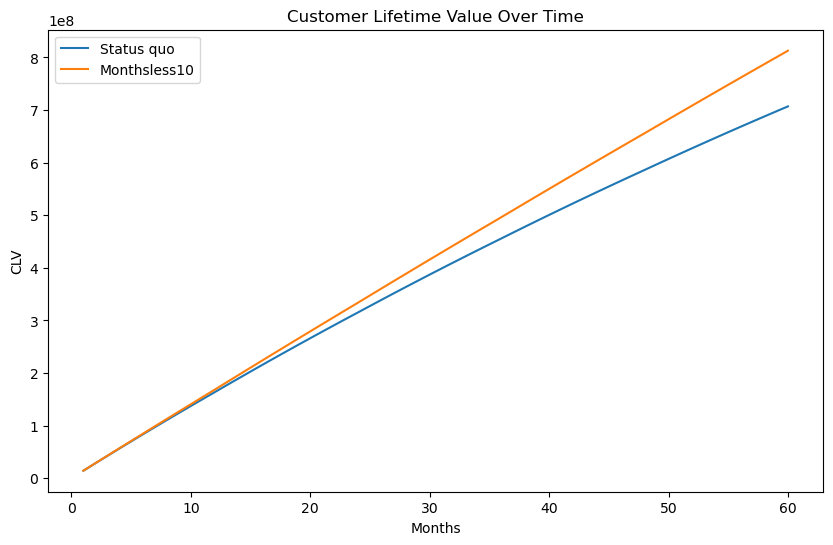

In [187]:
import matplotlib.pyplot as plt

# Plot the DataFrame
s_mobile_m.plot(x='Months', y=['Status quo', 'Monthsless10'], kind='line', figsize=(10, 6))

# Add title and labels
plt.title('Customer Lifetime Value Over Time')
plt.xlabel('Months')
plt.ylabel('CLV')

# Show the plot
plt.show()

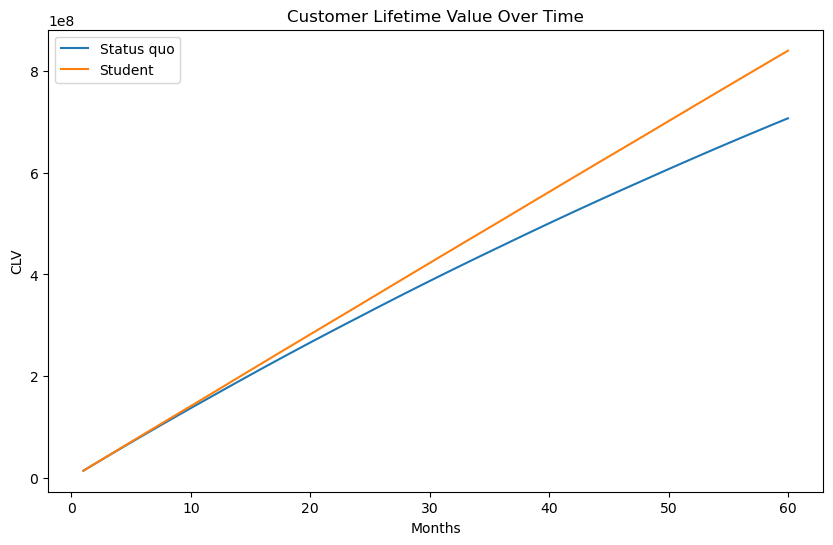

In [188]:
import matplotlib.pyplot as plt

# Plot the DataFrame
s_mobile_s.plot(x='Months', y=['Status quo', 'Student'], kind='line', figsize=(10, 6))

# Add title and labels
plt.title('Customer Lifetime Value Over Time')
plt.xlabel('Months')
plt.ylabel('CLV')

# Show the plot
plt.show()

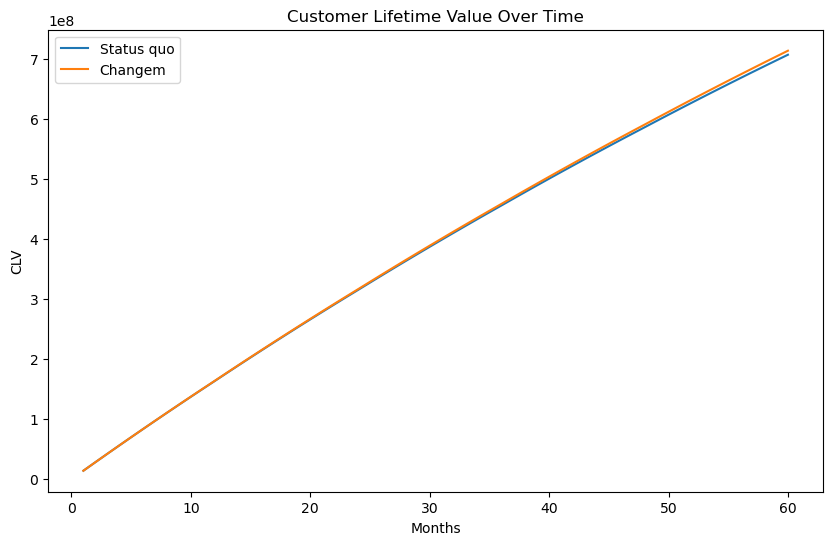

In [189]:
# Plot the DataFrame
s_mobile_c.plot(x='Months', y=['Status quo', 'Changem'], kind='line', figsize=(10, 6))

# Add title and labels
plt.title('Customer Lifetime Value Over Time')
plt.xlabel('Months')
plt.ylabel('CLV')

# Show the plot
plt.show()